In [1]:
import sys
import numpy as np
from pathlib import Path
from pyPolCal.csv_tools import write_fits_info_to_csv,read_csv,read_csv_physical_model_all_bins
from pyPolCal.fitting import *
from pyPolCal.utils import *
from pyPolCal.plotting import plot_data_and_model
from pyMuellerMat.physical_models.charis_physical_models import *
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
# Plot settings that I like
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "serif",
   # "font.serif": ["Palatino"],
    "font.size": 16,
   # "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathpazo}"
})
from pyPolCal.constants import wavelength_bins


/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1: Write FITS Info to CSV

This CSV writer will organize all relevant header information. Some header information is excluded from the extracted cubes but exists in the raw files. This function will match the info from raw headers by matching tags in the filenames. The CHARIS DPP rewrites these tags, so if you used the DPP at any point you will need to retitle all the frames to their original titles (there is a function in csv_tools.py to do this).

In [5]:
# Get paths to both processed and raw data 
# Make sure these directories have cubes with corresonding numbers
cube_dir = '/home/thomasmc/nbs_in/pol/cubes'
raw_dir = '/home/thomasmc/nbs_in/pol/raw'
csv_dir = '/home/thomasmc/nbs_in/pol/csvs'

# Write all bins to csvs
for bin in range(0,22):
   csv_filepath = f'/home/thomasmc/nbs_in/pol/csvs/bin{bin}.csv'
   write_fits_info_to_csv(cube_dir, raw_dir, csv_filepath,bin)



CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin0.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin1.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin2.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin3.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin4.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin5.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin6.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin7.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin8.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin9.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin10.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin11.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin12.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin13.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin14.csv
CSV file written to /home/thomasmc/nbs_in/pol/csvs/bin15.csv
CSV file written to /home/thomasmc

# Step 2 (Optional): Plot Your Data With the Original Model 

The csv reader will read in `interleaved_values`: interleaved single differences and sums `[differences, sums...]`, `interleaved_stds`:poissan noise propagated standard deviations (which are not used anymore and is an artifact of old code), and a `configuration_list` of dictionaries where each dictionary represents the instrument configuration for a measurement. The rationale for assuming no noise is that it is so tiny when normalized over large numbers of pixels it is irrelevant. It also improves fit accuracy.

In [2]:
# Define a csv filepath that we just created from whatever wavelength bin you want to visualize
# Weird things happen at the very lowest bins, so I recommend something more in the middle
filepath = Path('/home/thomasmc/nbs_in/pol/csvs/bin15.csv')

# Read in data

interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values[0 : 10])
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list[0 : 10])
print(interleaved_stds[0])

Interleaved Values
Length:  128
[ 7.00382131e+07  1.41851189e+08 -8.86489692e+07  1.45475467e+08
  4.90600351e+07  1.42335219e+08 -7.18919686e+07  1.44855901e+08
 -4.49567822e+06  1.43593626e+08]
Interleaved Stds
Length:  128
[11910.12968167 11910.12968167 12061.32113056 12061.32113056
 11930.43248421 11930.43248421 12035.60972251 12035.60972251
 11983.0557682  11983.0557682 ]
Configuration List
Length:  64
[{'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 11.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 56.25}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 22.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 67.5}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 33.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 78.75}, 'image_rotator': {'theta': 45.0}}, {'hwp': {'theta': 0.0}, 'image_rotator': {'theta': 57.5}}, {'hwp': {'theta': 45.0}, 'image_rotator': {'th

The Mueller matrix chain is contained in a pyMuellerMat system Mueller matrix object. These are generated using configuration dictionaries with the below format. You can generate a system dictionary with any function listed in the common_mm_functions.py script in the pyMuellerMat physical_models branch (can be found here: https://github.com/maxwellmb/pyMuellerMat/tree/physical_models/pyMuellerMat). Each component is within a `components` dictionary, listed from downstream to upstream. You can name each component, and give it a `type` which is the name of the commmon mm function. The `properties` are the case sensitive inputs to these functions. Tag each component as `internal`. With this system dict you can create your Mueller matrix with `generate_system_mueller_matrix()`.

In [3]:

# Loading in past fits 

offset_imr = 0.18563 # derotator offset
offset_hwp = -0.87823 # HWP offset
offset_cal = -0.44630 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0



# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            'nbs_rot' : {
                "type" : "rotator_function",
                "properties" : {'pa':90},
                "tag": "internal",
            },
            "image_rotator" : {
                "type" : "elliptical_retarder_function",
                "properties" : {"phi_h": 1, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon": 1, "delta_theta": 0},
                "tag": "internal",
            }},
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())



[[9.65044427e-06 9.65044427e-06 0.00000000e+00 0.00000000e+00]
 [9.65044427e-06 9.65044427e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


Here is where we can load in our old fit. The fit I have loaded in is my median posterior MCMC fit of the Joost 't Hart 2021 physical model. The physical model is contained in functions from the physical_models branch of pyMuellerMat. The fit is not very good, which prompted the switch to an elliptical polarizer model for the derotator. `p` and `system_parameters` are updates that will be placed into the Mueller matrix. This is because plotting function is made to use the same workflow as `minimize_system_mueller_matrix()` (If you would prefer to work without my wrapper function, follow the same procedure here to generate the model).

`p` is the float values of the parameters detailed in `system_parameters` which contains the float value's component name and what `property` it is in the `system_dict`. `modeled_interleaved` are the modeled single sums and differences generated from the `system_mm` and updated p values, which we then process into double sums and differences using `process_model()`. Note that, for CHARIS, the sums are irrelevant. `plot_data_and_model()` plots the double differences vs. HWP angle for all derotator angles. 

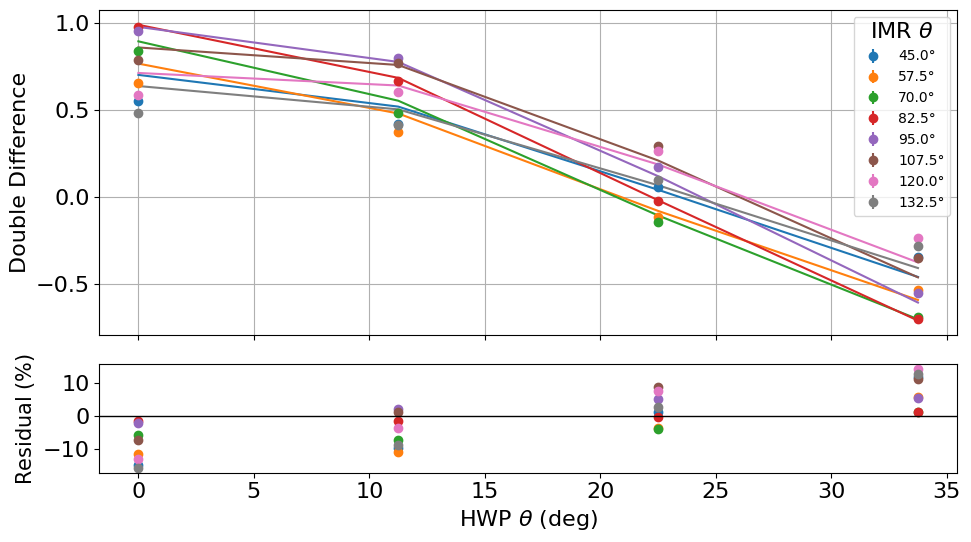

[ 0.70059107  0.51827757  0.04025134 -0.46076512  0.76538261  0.4788211
 -0.08110064 -0.59298301  0.89331766  0.55219547 -0.10736466 -0.7036567
  0.98847824  0.68343219 -0.01996717 -0.7115214   0.97632933  0.77507854
  0.11837731 -0.60777368  0.85819587  0.75751236  0.20852258 -0.46295755
  0.71169431  0.6394591   0.1857813  -0.37723619  0.63655217  0.5024747
  0.06619268 -0.40945067]


np.float64(8.936636291239372)

In [4]:

# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins,1.66725,1.30159)[15], IMR_retardance(wavelength_bins,259.14673)[15]]


# Define what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi_h']]

# Generate our modeled left and right beam intensities

modeled_interleaved = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(modeled_interleaved)

# Plot the modeled and observed values

fig, ax = plot_data_and_model(interleaved_values, diffs_sums,configuration_list, wavelength= wavelength_bins[15],include_sums=False,title='')
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#fig.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/MCMC_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)
diffs = process_dataset(interleaved_values)[::2]
print(diffs_sums[::2])
pol_acc = np.sqrt(np.sum((diffs*100-diffs_sums[::2]*100)**2)/(len(diffs)-6))
pol_acc

# Step 3: Fit for Retardances

ABOUT THE FITTING FUNCTION/HOW I USE IT: I made a function that does everything quickly but is also tailored to the parameters I am fitting. My function fits using scipy least squares, updates the model, puts the pyMuellerMat compatible system dictionary in a JSON file, and optionally saves a plot of the model vs data to a specified path.
If you want to use it for different parameters than the ones in the p0 dictionary within the function, 
you'll have to update the function a bit (which shouldn't take too long). This is a wrapper function for the main minimization function in fitting.py. I've found it easier to use this function and tailor the parameters that it's fitting to what I need instead of using that fitting function. The things you need to edit in this function in instruments.py to fit new parameters are marked with all caps comments that look like this: # IF YOU WANT TO MODIFY YOUR PARAMETERS, EDIT THIS

This funciton calculates s_res, which is a metric used in previous polcal papers to quantify goodness of fit. It's essentially a corrected average of residuals. It also calculates error on fit from a Jacobian estimation technique from Rob Van Holstein's 2020 VLT SPHERE polcal paper.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5600e-02                                    6.04e+00    
       1              2         1.1311e-02      4.43e-02       9.57e-02       1.09e-01    
       2              3         1.1192e-02      1.19e-04       4.05e-03       6.61e-04    
       3              4         1.1187e-02      4.94e-06       1.30e-03       3.53e-04    
       4              5         1.1187e-02      3.01e-08       1.06e-04       1.30e-05    
       5              6         1.1187e-02      3.68e-12       1.41e-06       1.16e-06    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 5.5600e-02, final cost 1.1187e-02, first-order optimality 1.16e-06.
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 6.838e-03  2.522e-02 ...  8.100e-03  2.194e-02]
           x: [ 1.013e+00  9.010e-02  3.547e-02  3.044e+00 

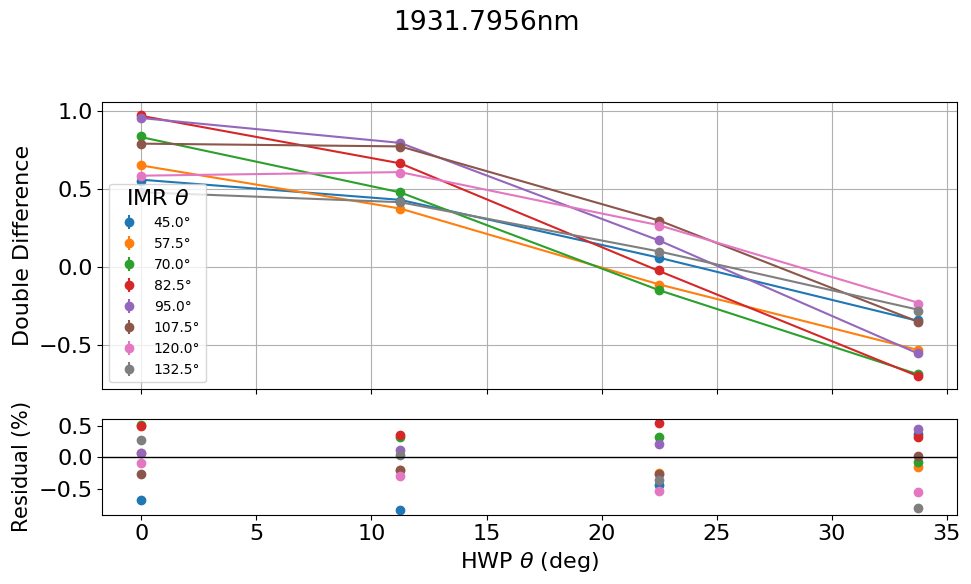

Updated Mueller Matrix:
[[ 0.66486695  0.66486695  0.          0.        ]
 [-0.66065629 -0.66065629  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.845012983847127 0.5347645561703525
s_res: 0.4517281081265634
Error: [0.00910502 0.00594046 0.01091701 0.00814888 0.00724194]


/tmp/ipykernel_3014856/139288076.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


In [5]:
# Test fitting with the wavelength bin we plotted earlier
from pyPolCal.instruments import fit_CHARIS_Mueller_matrix_by_bin_nbs
error, fig2, ax2,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs(filepath, 15, 
    Path('/home/thomasmc/nbs_in/pol/sys_dicts/test.json'),
    )
ax2.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax2.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax2.minorticks_on()
fig2.suptitle('')
fig2.show()
#fig2.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/overleaf_plots/naive_model_single_diff_vs_hwp_1932.png',bbox_inches='tight', dpi=600)



The elliptical IMR model is a huge improvement! Now we can fit for all bins. In this fit, I'm fitting for 3 elliptical retarder parameters and a Wollaston prism modulator term.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5643e-02                                    1.14e+00    
       1              2         1.4086e-02      3.16e-02       1.06e-01       2.02e-01    
       2              3         1.2716e-02      1.37e-03       2.39e-02       4.31e-03    
       3              4         1.2534e-02      1.82e-04       1.85e-03       4.99e-05    
       4              5         1.2510e-02      2.39e-05       2.65e-04       1.37e-06    
       5              6         1.2510e-02      4.61e-07       5.18e-06       2.81e-08    
       6              7         1.2510e-02      1.76e-10       3.40e-09       1.20e-08    
`xtol` termination condition is satisfied.
Function evaluations 7, initial cost 4.5643e-02, final cost 1.2510e-02, first-order optimality 1.20e-08.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 9.524e-03  1.681

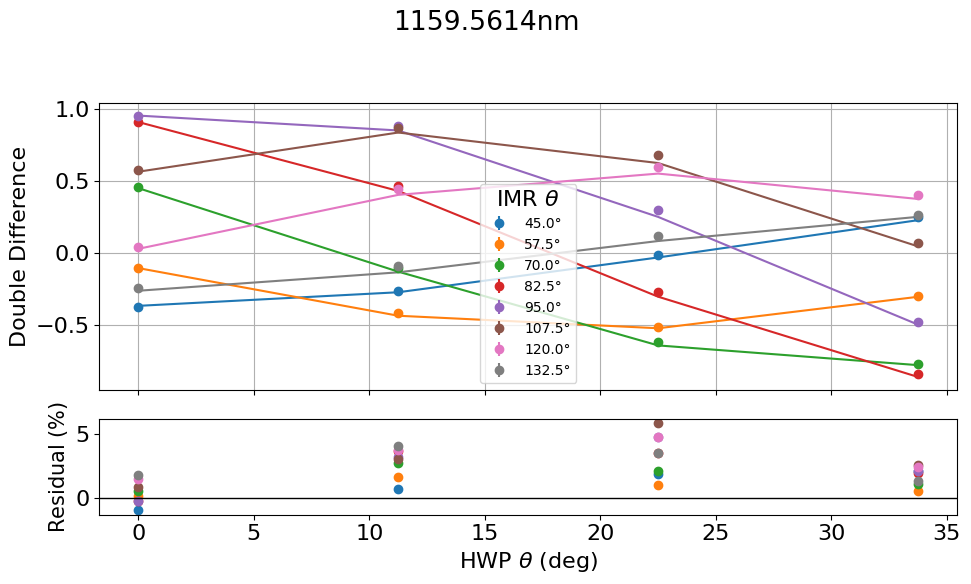

Updated Mueller Matrix:
[[ 0.34048165  0.34048165  0.          0.        ]
 [-0.34048165 -0.34048165  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.9523949389477693 5.801054413867156
s_res: 3.044340875457277
Error: [0.00779143 0.02393589 0.01771494 0.00755471 0.00766679]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2207e-02                                    1.66e+00    
       1              2         1.0864e-02      3.13e-02       1.30e-01       1.04e-01    
       2              3         1.0758e-02      1.06e-04       8.03e-03       1.14e-03    
       3              4         1.0757e-02      1.59e-06       7.54e-04       1.85e-05    
       4              5         1.0757e-02      6.08e-09       4.95e-05       9.49e-07    
       5              6         1.0757e-02      1.26e-13       2.33e-07   

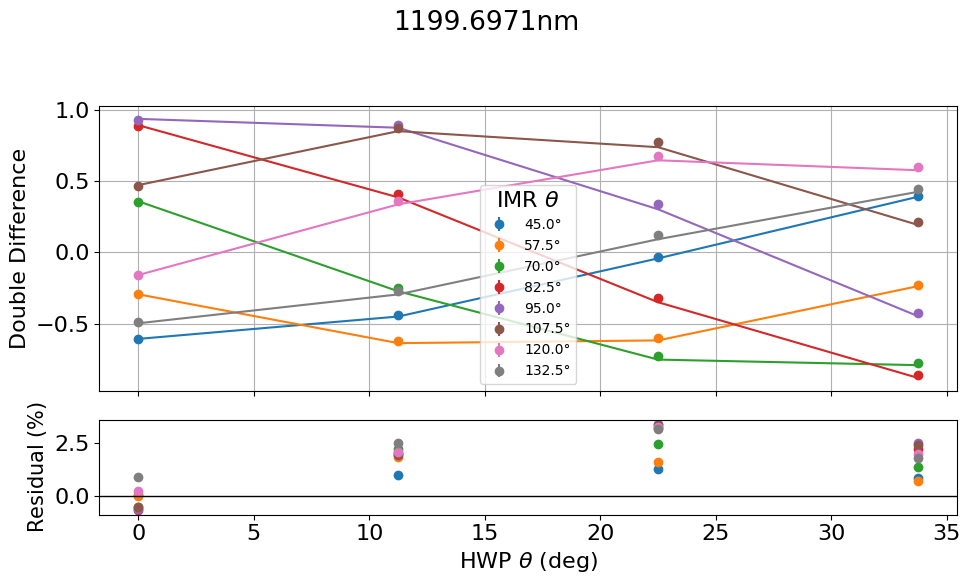

Updated Mueller Matrix:
[[ 0.25221875  0.25221875  0.          0.        ]
 [-0.24511193 -0.24511193  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6819683768730869 3.387996509589616
s_res: 2.2791983095801944
Error: [0.0092979  0.02394891 0.01314077 0.00816443 0.00709385]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4031e-02                                    2.34e+00    
       1              2         4.9551e-03      3.91e-02       1.48e-01       1.40e-01    
       2              3         4.7473e-03      2.08e-04       9.44e-03       5.68e-04    
       3              4         4.7347e-03      1.26e-05       2.12e-03       6.69e-05    
       4              5         4.7340e-03      6.60e-07       5.70e-04       2.08e-05    
       5              6         4.7340e-03      3.88e-09       4.72e-05  

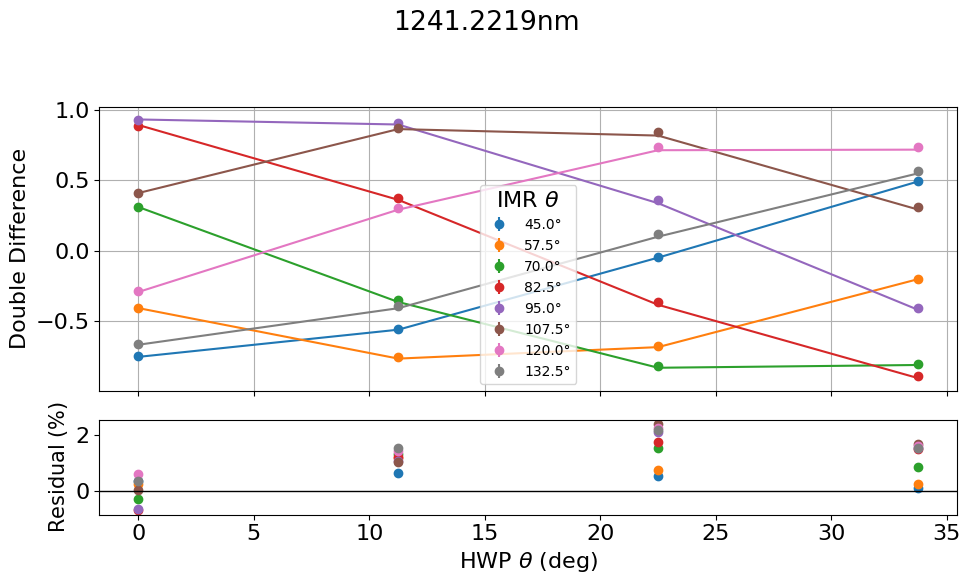

Updated Mueller Matrix:
[[ 0.19791279  0.19791279  0.          0.        ]
 [-0.1940654  -0.1940654   0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6937460745702566 2.404097620403263
s_res: 1.4949638545885997
Error: [0.00793022 0.01778252 0.00748593 0.00644517 0.0046982 ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.0093e-02                                    3.26e+00    
       1              2         4.3259e-03      4.58e-02       1.95e-01       1.68e-01    
       2              3         3.5573e-03      7.69e-04       1.94e-02       3.43e-03    
       3              4         3.5162e-03      4.10e-05       5.39e-03       2.00e-04    
       4              5         3.5152e-03      1.06e-06       1.02e-03       5.92e-05    
       5              6         3.5152e-03      1.46e-09       4.25e-05  

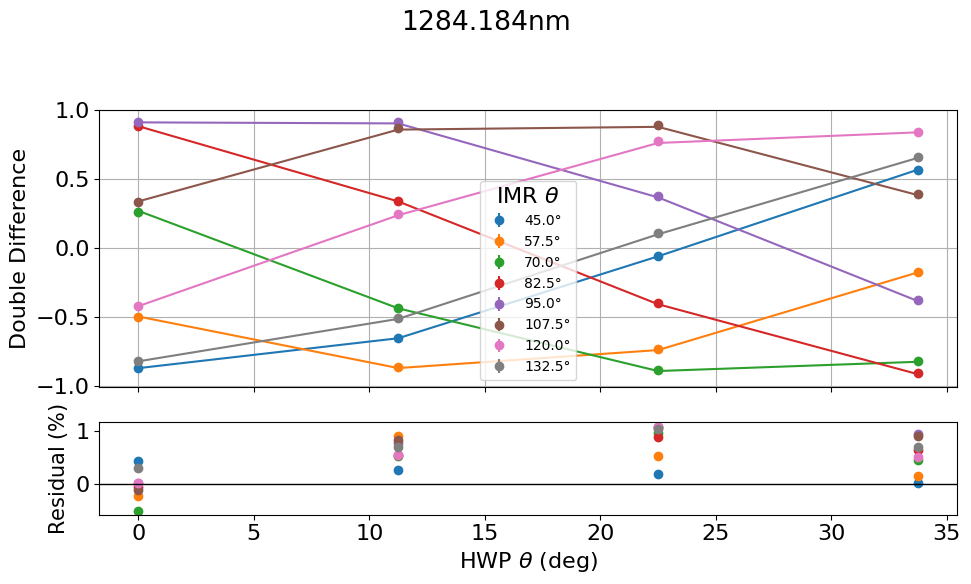

Updated Mueller Matrix:
[[ 0.15728563  0.15728563  0.          0.        ]
 [-0.14425732 -0.14425732  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.5059833326174612 1.0925048839853702
s_res: 0.7648368165657808
Error: [0.01023543 0.0198177  0.00565454 0.00773138 0.00404051]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9895e-02                                    3.99e+00    
       1              2         1.1586e-02      3.83e-02       1.12e-01       1.36e-01    
       2              3         1.1463e-02      1.24e-04       1.45e-02       1.02e-02    
       3              4         1.1431e-02      3.19e-05       1.10e-02       7.86e-03    
       4              5         1.1411e-02      1.91e-05       8.55e-03       6.22e-03    
       5              6         1.1398e-02      1.30e-05       7.31e-03 

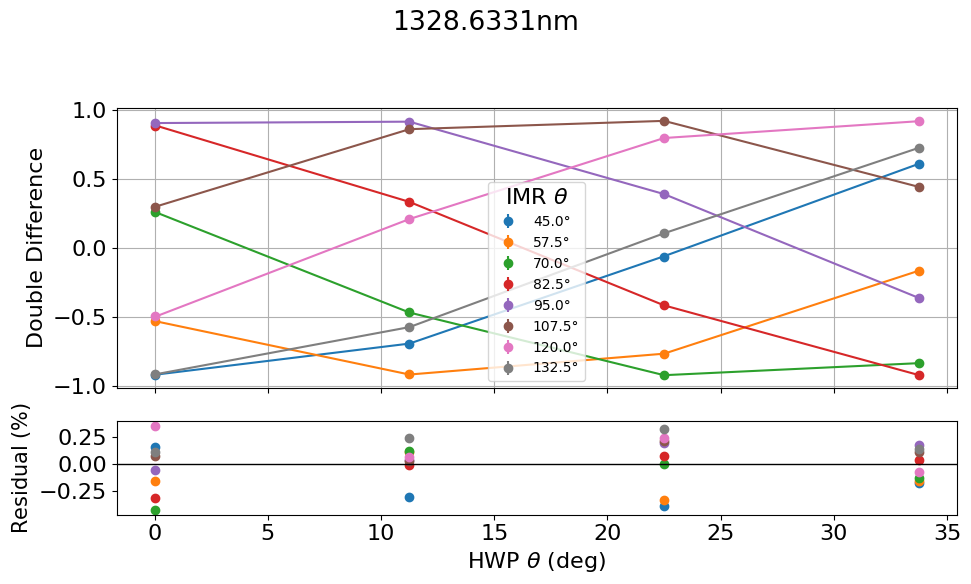

Updated Mueller Matrix:
[[ 0.13848637  0.13848637  0.          0.        ]
 [-0.12574036 -0.12574036  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.43486377393832143 0.35274574203447173
s_res: 0.23446471995373286
Error: [0.0180754  0.0260808  0.00482395 0.01287529 0.00475061]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7671e-02                                    4.23e+00    
       1              2         4.3144e-03      3.34e-02       1.13e-01       2.58e-02    
       2              3         4.2440e-03      7.04e-05       3.24e-03       3.10e-04    
       3              4         4.2396e-03      4.42e-06       2.18e-03       9.17e-05    
       4              5         4.2396e-03      3.82e-08       2.34e-04       1.31e-05    
       5              6         4.2396e-03      1.74e-11       6.58e-

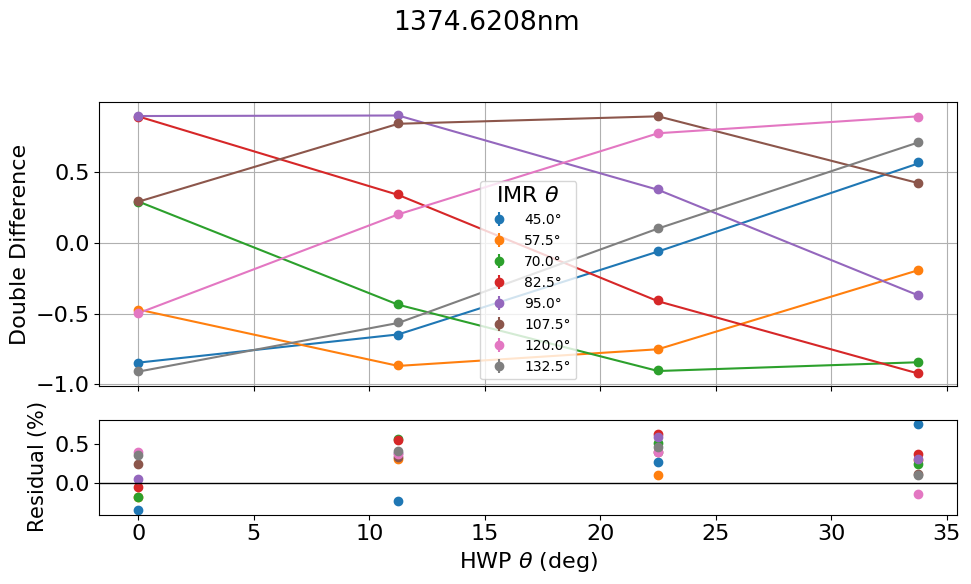

Updated Mueller Matrix:
[[ 0.16397728  0.16397728  0.          0.        ]
 [-0.15549238 -0.15549238  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.35941599795413026 0.7601414885264859
s_res: 0.4361351299892186
Error: [0.01321462 0.01730246 0.00445384 0.01023775 0.004339  ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4083e-02                                    4.36e+00    
       1              2         1.9854e-03      3.21e-02       9.23e-02       7.58e-02    
       2              3         1.9463e-03      3.91e-05       3.53e-03       5.44e-04    
       3              4         1.9455e-03      7.83e-07       6.90e-04       1.32e-04    
       4              5         1.9455e-03      8.94e-10       2.54e-05       4.76e-06    
       5              6         1.9455e-03      6.79e-13       8.60e-07

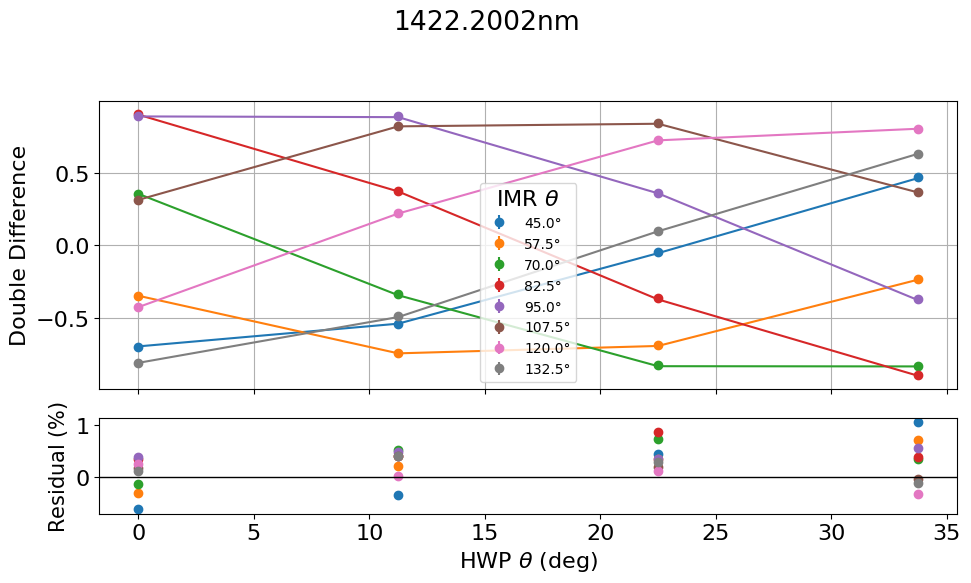

Updated Mueller Matrix:
[[ 0.2178231  0.2178231  0.         0.       ]
 [-0.2069774 -0.2069774  0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]]
128 64
Residuals range: -0.6107178554129291 1.0551296521719067
s_res: 0.5098991658438261
Error: [0.00589398 0.00778584 0.00296269 0.00479466 0.00297038]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9575e-02                                    3.80e+00    
       1              2         1.9628e-03      2.76e-02       9.48e-02       6.96e-02    
       2              3         1.9206e-03      4.22e-05       3.79e-03       7.33e-04    
       3              4         1.9197e-03      8.29e-07       5.59e-04       7.30e-05    
       4              5         1.9197e-03      9.76e-10       1.98e-05       2.88e-06    
       5              6         1.9197e-03      5.97e-14       2.16e-07       6.41e-08  

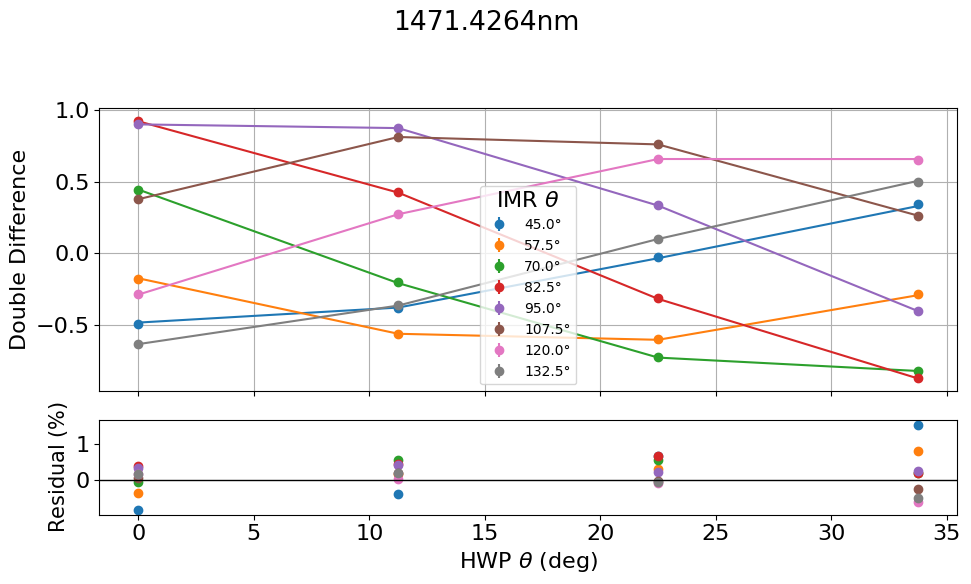

Updated Mueller Matrix:
[[ 0.29454818  0.29454818  0.          0.        ]
 [-0.28527273 -0.28527273  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.8653818085529181 1.5511676946680168
s_res: 0.5539923942839764
Error: [0.00403326 0.00541567 0.002941   0.00358261 0.00297984]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5940e-02                                    3.03e+00    
       1              2         1.6851e-03      2.43e-02       9.35e-02       4.75e-02    
       2              3         1.6436e-03      4.15e-05       3.51e-03       4.27e-04    
       3              4         1.6428e-03      7.70e-07       4.81e-04       4.48e-05    
       4              5         1.6428e-03      8.19e-10       1.61e-05       1.54e-06    
       5              6         1.6428e-03      1.01e-14       7.05e-08 

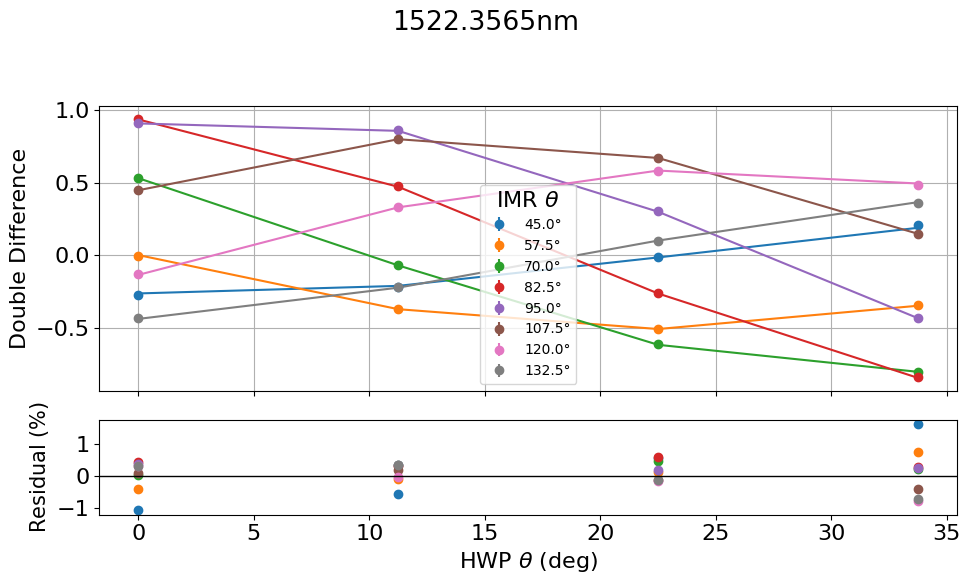

Updated Mueller Matrix:
[[ 0.37336135  0.37336135  0.          0.        ]
 [-0.36505851 -0.36505851  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.0870145749437121 1.6322401666169775
s_res: 0.593273502550616
Error: [0.00297507 0.00394692 0.00279656 0.00288866 0.00276519]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8425e-02                                    2.43e+00    
       1              2         6.8516e-04      2.77e-02       9.99e-02       3.59e-02    
       2              3         6.2073e-04      6.44e-05       4.00e-03       1.47e-04    
       3              4         6.1918e-04      1.55e-06       6.38e-04       6.47e-06    
       4              5         6.1918e-04      3.42e-09       3.13e-05       2.78e-07    
       5              6         6.1918e-04      2.10e-14       7.88e-08  

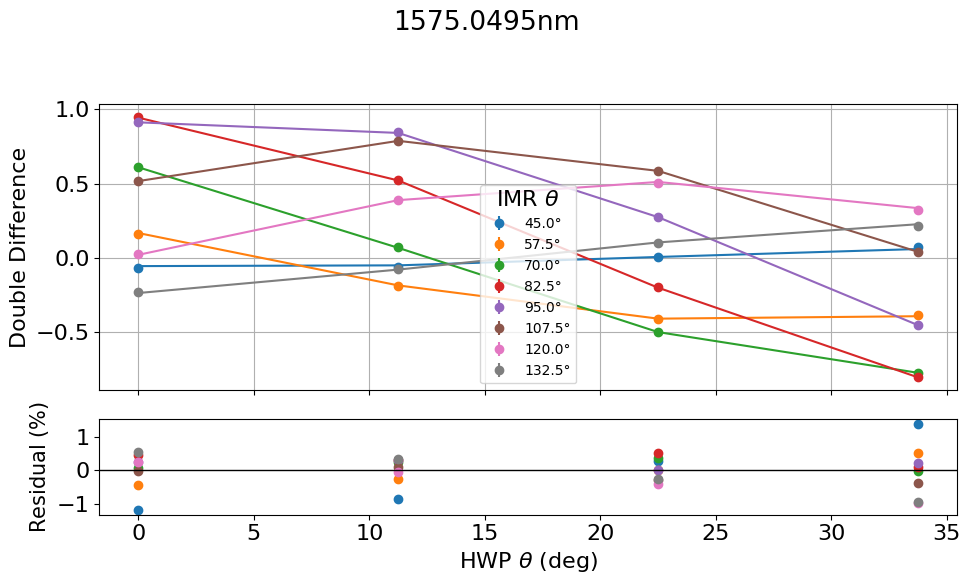

Updated Mueller Matrix:
[[ 0.44593774  0.44593774  0.          0.        ]
 [-0.43891424 -0.43891424  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.2072738244452594 1.4135476982701416
s_res: 0.6010574786058374
Error: [0.00162336 0.0020438  0.00179744 0.0016683  0.00169989]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3647e-02                                    3.24e+00    
       1              2         2.4985e-03      3.11e-02       1.01e-01       4.34e-02    
       2              3         2.4110e-03      8.75e-05       4.32e-03       2.96e-04    
       3              4         2.4088e-03      2.18e-06       7.45e-04       4.39e-05    
       4              5         2.4088e-03      5.74e-09       4.01e-05       2.51e-06    
       5              6         2.4088e-03      8.43e-14       1.50e-07 

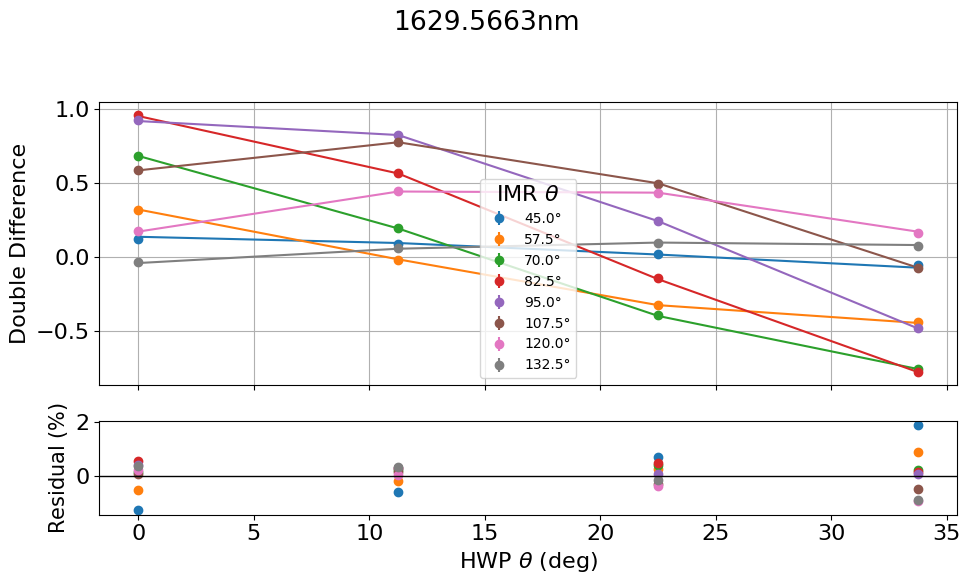

Updated Mueller Matrix:
[[ 0.51679191  0.51679191  0.          0.        ]
 [-0.51019629 -0.51019629  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.259912530683577 1.884610387612189
s_res: 0.6660159235357171
Error: [0.00313003 0.00352976 0.00379095 0.00325392 0.00335435]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6548e-02                                    4.03e+00    
       1              2         3.0973e-03      3.35e-02       9.84e-02       6.20e-02    
       2              3         3.0011e-03      9.62e-05       4.25e-03       1.89e-04    
       3              4         2.9986e-03      2.45e-06       8.06e-04       3.80e-05    
       4              5         2.9986e-03      6.93e-09       4.51e-05       2.85e-06    
       5              6         2.9986e-03      1.82e-13       2.29e-07   

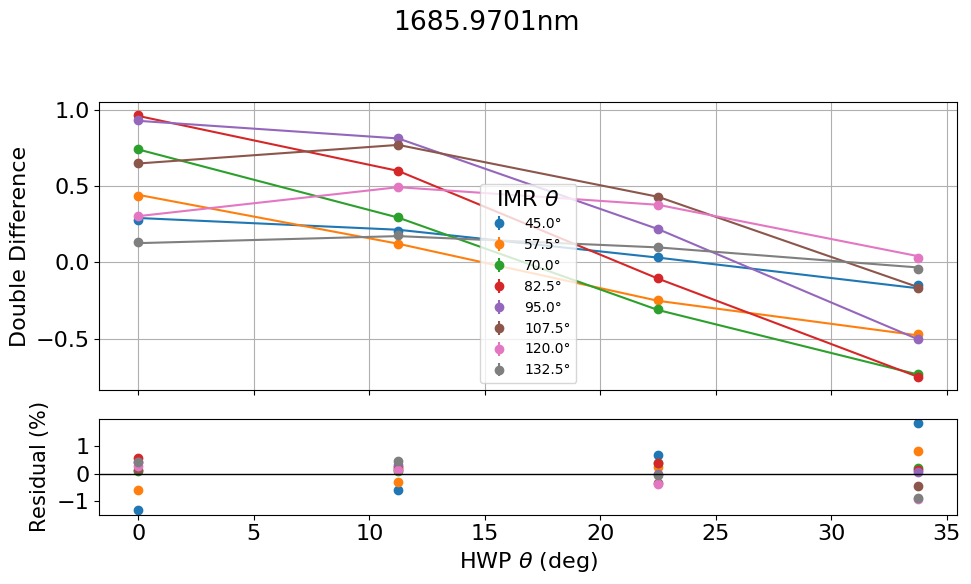

Updated Mueller Matrix:
[[ 0.57153635  0.57153635  0.          0.        ]
 [-0.56556931 -0.56556931  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.325013468974916 1.8332093139227759
s_res: 0.6695230586612235
Error: [0.00365849 0.00359388 0.00454487 0.00371004 0.00374229]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8651e-02                                    4.82e+00    
       1              2         6.3599e-04      3.80e-02       9.95e-02       8.00e-02    
       2              3         5.2555e-04      1.10e-04       4.21e-03       1.00e-04    
       3              4         5.2134e-04      4.20e-06       1.06e-03       1.07e-05    
       4              5         5.2132e-04      2.57e-08       8.92e-05       1.14e-06    
       5              6         5.2132e-04      1.34e-12       6.53e-07  

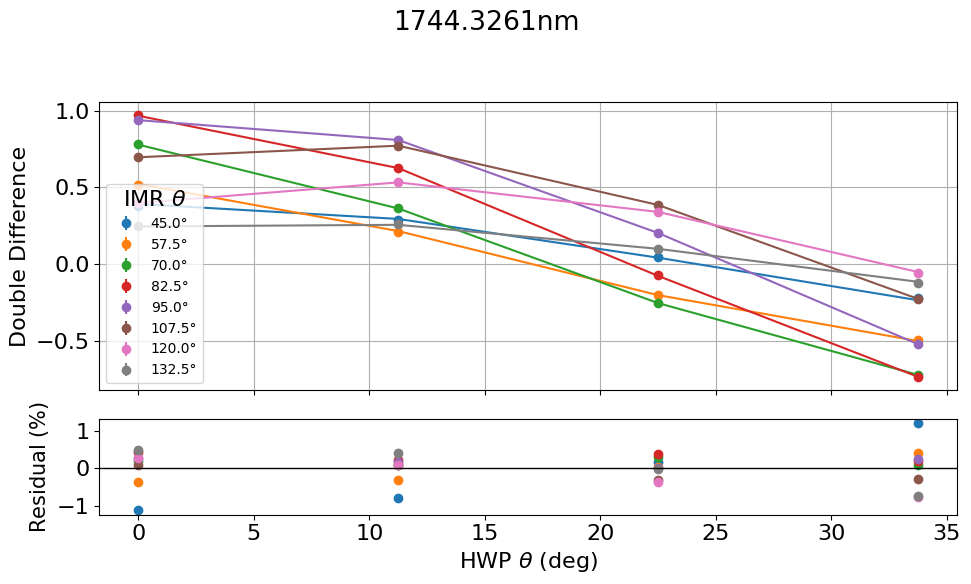

Updated Mueller Matrix:
[[ 0.60661283  0.60661283  0.          0.        ]
 [-0.60202164 -0.60202164  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.1300860715514531 1.2092755454887012
s_res: 0.5207237596748509
Error: [0.00162393 0.00141136 0.00201231 0.00159262 0.00156048]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4945e-02                                    5.54e+00    
       1              2         5.8595e-04      4.44e-02       1.03e-01       1.15e-01    
       2              3         4.4855e-04      1.37e-04       4.53e-03       1.27e-04    
       3              4         4.4317e-04      5.38e-06       1.25e-03       4.12e-05    
       4              5         4.4314e-04      3.33e-08       1.05e-04       3.66e-06    
       5              6         4.4314e-04      1.77e-12       7.73e-07 

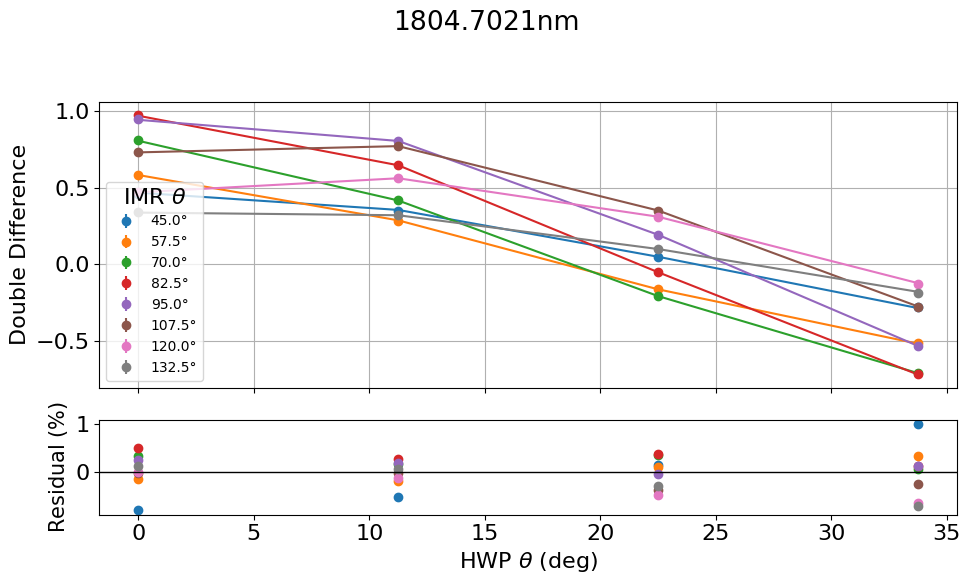

Updated Mueller Matrix:
[[ 0.63276599  0.63276599  0.          0.        ]
 [-0.62797852 -0.62797852  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.8091342469927838 1.0024419197986951
s_res: 0.43298195556027447
Error: [0.0016064  0.00124992 0.00196848 0.00152423 0.00143876]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2412e-02                                    5.99e+00    
       1              2         6.4906e-03      4.59e-02       9.99e-02       1.17e-01    
       2              3         6.3574e-03      1.33e-04       4.28e-03       2.14e-04    
       3              4         6.3513e-03      6.04e-06       1.37e-03       2.75e-04    
       4              5         6.3513e-03      4.68e-08       1.29e-04       2.06e-05    
       5              6         6.3513e-03      5.70e-12       1.59e-06

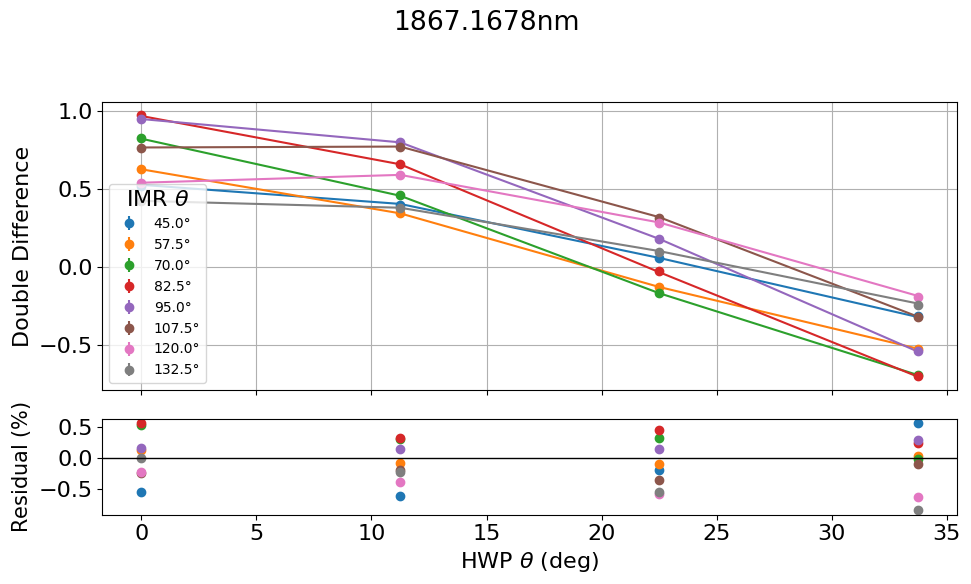

Updated Mueller Matrix:
[[ 0.65307192  0.65307192  0.          0.        ]
 [-0.64888311 -0.64888311  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.8339420677768743 0.5586204468447278
s_res: 0.43369062079439047
Error: [0.0065267  0.00456626 0.00789495 0.00598236 0.00545144]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5600e-02                                    6.04e+00    
       1              2         1.1311e-02      4.43e-02       9.57e-02       1.09e-01    
       2              3         1.1192e-02      1.19e-04       4.05e-03       6.61e-04    
       3              4         1.1187e-02      4.94e-06       1.30e-03       3.53e-04    
       4              5         1.1187e-02      3.01e-08       1.06e-04       1.30e-05    
       5              6         1.1187e-02      3.68e-12       1.41e-06

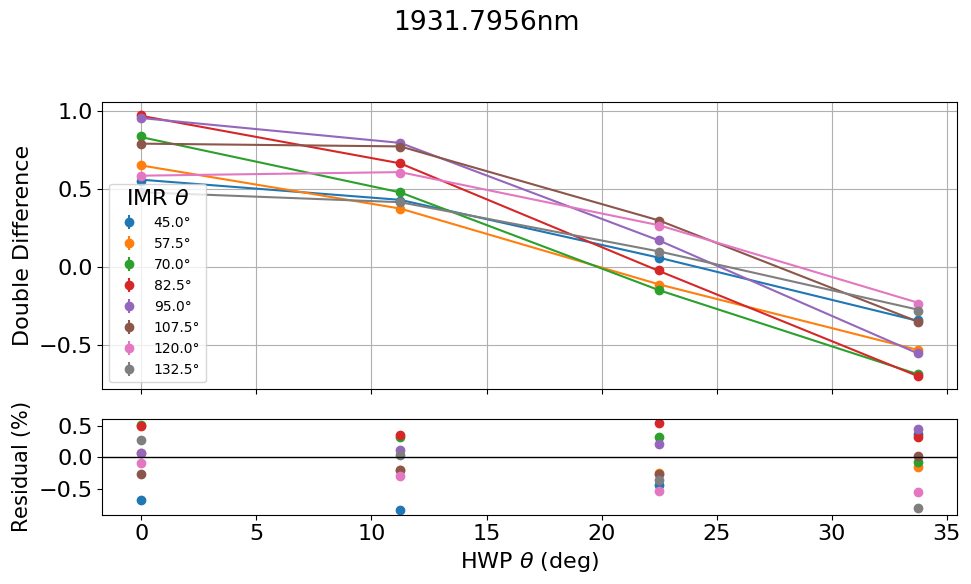

Updated Mueller Matrix:
[[ 0.66486695  0.66486695  0.          0.        ]
 [-0.66065629 -0.66065629  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.845012983847127 0.5347645561703525
s_res: 0.4517281081265634
Error: [0.00910502 0.00594046 0.01091701 0.00814888 0.00724194]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0778e-02                                    6.27e+00    
       1              2         1.4022e-02      4.68e-02       9.80e-02       1.13e-01    
       2              3         1.3893e-02      1.29e-04       4.12e-03       7.99e-04    
       3              4         1.3886e-02      7.34e-06       1.55e-03       4.01e-04    
       4              5         1.3886e-02      8.98e-08       1.86e-04       2.39e-05    
       5              6         1.3886e-02      2.61e-11       3.50e-06  

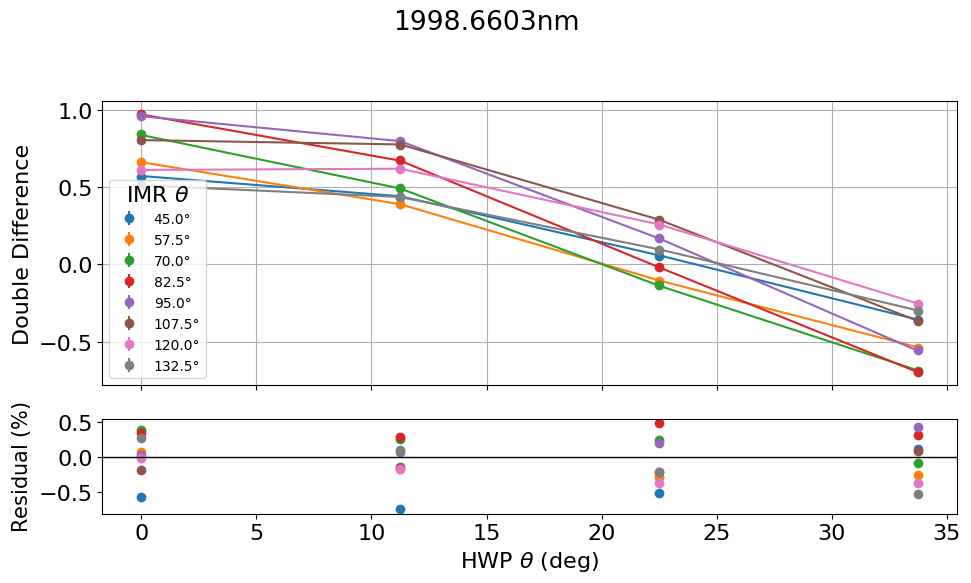

Updated Mueller Matrix:
[[ 0.66933905  0.66933905  0.          0.        ]
 [-0.66601075 -0.66601075  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.7558403468225592 0.47796800281575913
s_res: 0.36758701810053246
Error: [0.01039623 0.00653086 0.01241267 0.00916947 0.00807646]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0149e-02                                    6.28e+00    
       1              2         1.3251e-02      4.69e-02       9.94e-02       1.04e-01    
       2              3         1.3119e-02      1.33e-04       4.22e-03       6.60e-04    
       3              4         1.3113e-02      6.03e-06       1.47e-03       2.70e-04    
       4              5         1.3113e-02      4.03e-08       1.27e-04       1.02e-05    
       5              6         1.3113e-02      4.30e-12       1.47e-0

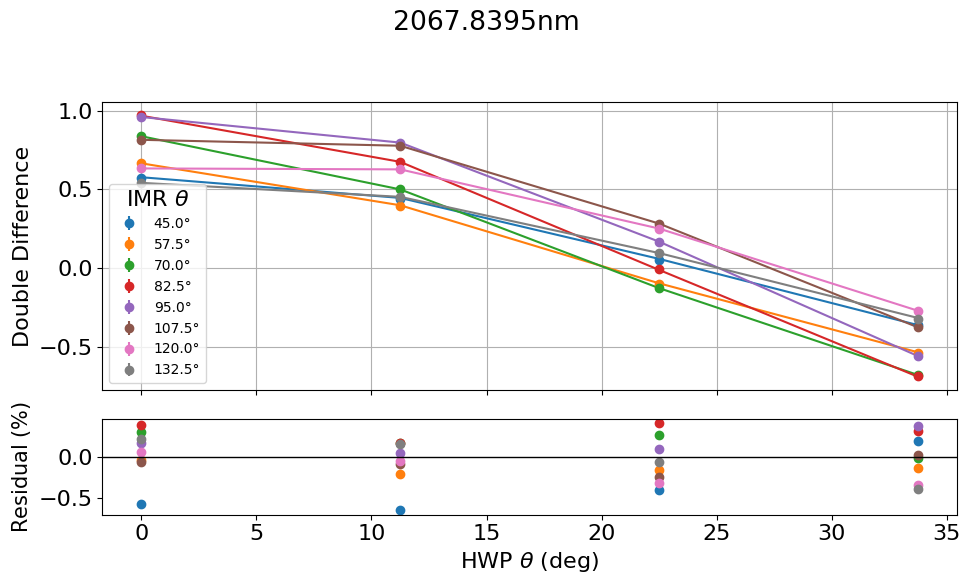

Updated Mueller Matrix:
[[ 0.67108136  0.67108136  0.          0.        ]
 [-0.66672671 -0.66672671  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6471141870321588 0.4030693035861286
s_res: 0.31226524790921434
Error: [0.0103614  0.00631398 0.01233193 0.00902415 0.00785635]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2464e-02                                    6.22e+00    
       1              2         1.5811e-02      4.67e-02       1.01e-01       9.43e-02    
       2              3         1.5676e-02      1.36e-04       4.31e-03       8.99e-04    
       3              4         1.5669e-02      6.90e-06       1.55e-03       1.84e-04    
       4              5         1.5669e-02      5.78e-08       1.53e-04       1.01e-05    
       5              6         1.5669e-02      6.95e-12       1.73e-06

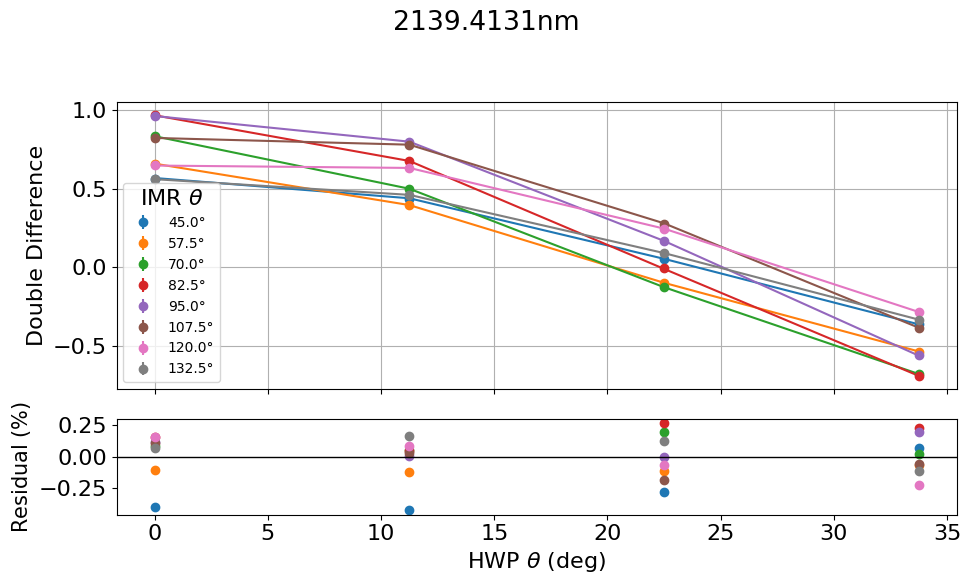

Updated Mueller Matrix:
[[ 0.66864765  0.66864765  0.          0.        ]
 [-0.66453902 -0.66453902  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.42784318441303526 0.26375519734328756
s_res: 0.19526930854271896
Error: [0.01138722 0.00687689 0.01354676 0.00985838 0.00859412]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0734e-02                                    5.90e+00    
       1              2         1.6905e-02      4.38e-02       1.01e-01       8.44e-02    
       2              3         1.6776e-02      1.30e-04       4.39e-03       7.25e-04    
       3              4         1.6772e-02      4.04e-06       1.23e-03       4.69e-05    
       4              5         1.6772e-02      1.11e-08       6.73e-05       2.44e-06    
       5              6         1.6772e-02      1.45e-13       2.47e-

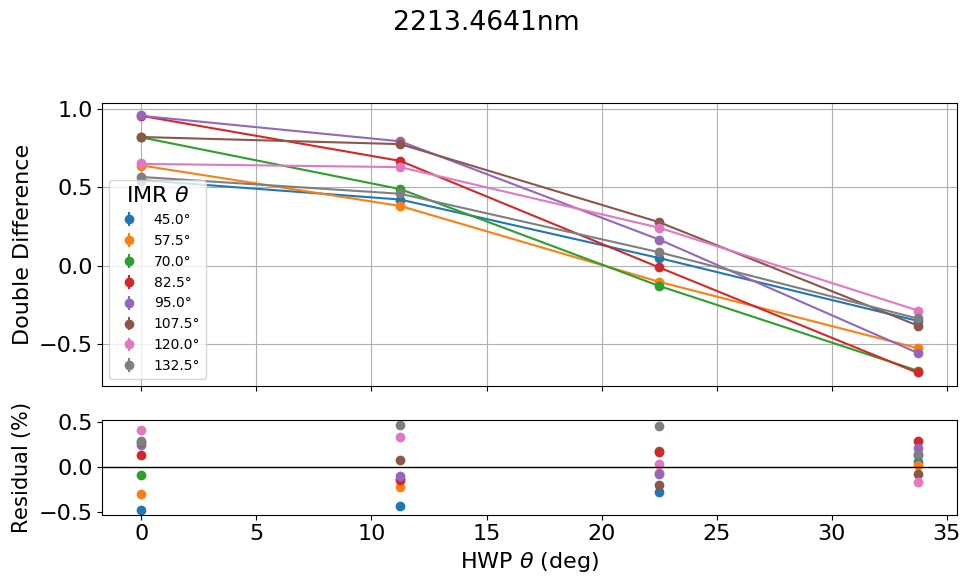

Updated Mueller Matrix:
[[ 0.66246039  0.66246039  0.          0.        ]
 [-0.65637901 -0.65637901  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.4873584256861392 0.47563934170615596
s_res: 0.2891300466006336
Error: [0.01178732 0.00716706 0.01403414 0.01020873 0.00889173]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5205e-02                                    6.08e+00    
       1              2         1.5973e-02      4.92e-02       1.11e-01       1.22e-01    
       2              3         1.5794e-02      1.80e-04       5.40e-03       1.22e-03    
       3              4         1.5790e-02      3.96e-06       1.22e-03       1.43e-04    
       4              5         1.5790e-02      5.96e-09       4.80e-05       1.03e-05    
       5              6         1.5790e-02      9.45e-13       6.01e-07

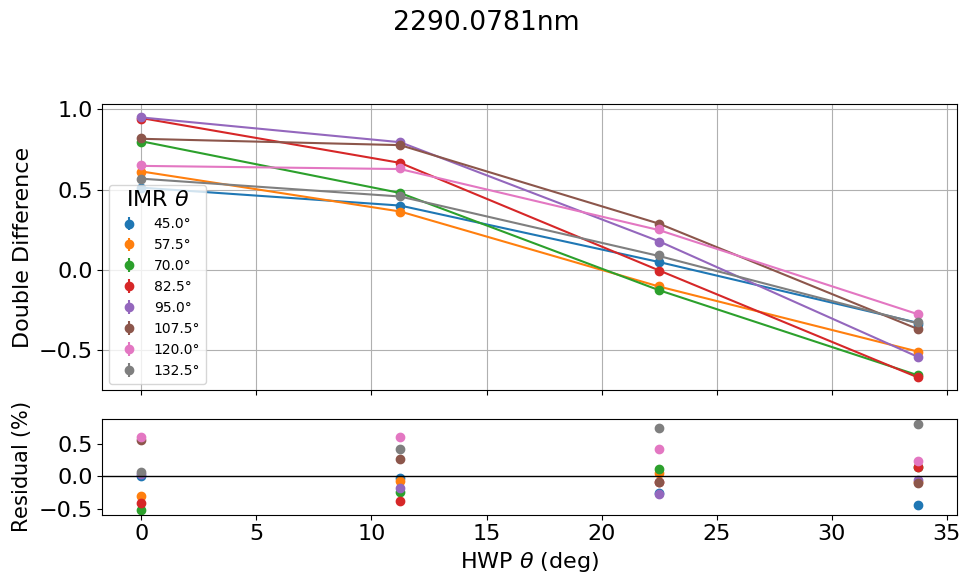

Updated Mueller Matrix:
[[ 0.64999795  0.64999795  0.          0.        ]
 [-0.64121217 -0.64121217  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.5226929833052765 0.8097212516755974
s_res: 0.4053008268403472
Error: [0.01135106 0.0070463  0.01352967 0.00989169 0.00862067]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1265e-02                                    5.31e+00    
       1              2         1.7950e-02      4.33e-02       1.09e-01       1.31e-01    
       2              3         1.7787e-02      1.63e-04       5.86e-03       2.33e-03    
       3              4         1.7786e-02      8.22e-07       5.56e-04       1.51e-04    
       4              5         1.7786e-02      2.68e-10       9.36e-06       1.65e-05    
       5              6         1.7786e-02      1.70e-12       8.81e-07 

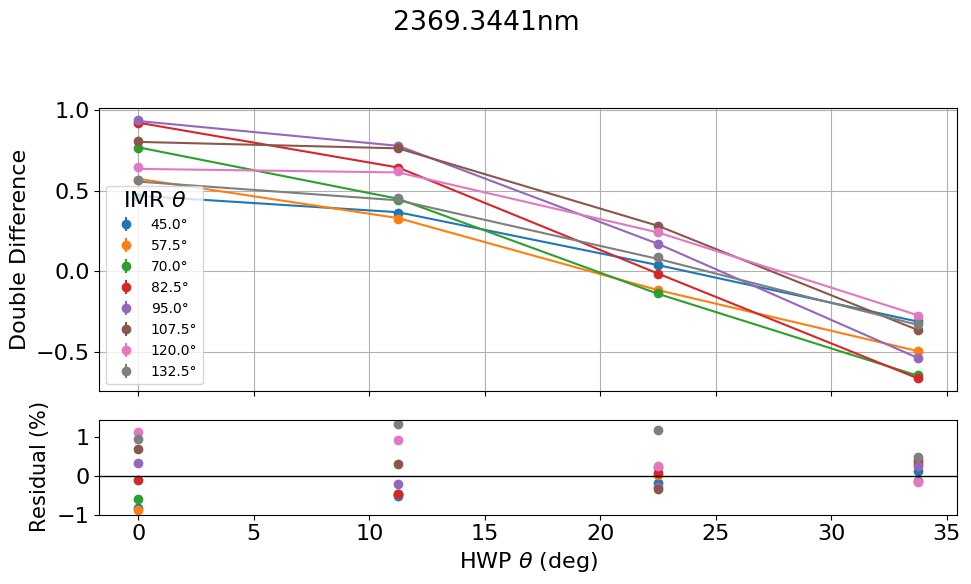

Updated Mueller Matrix:
[[ 0.63721208  0.63721208  0.          0.        ]
 [-0.62048545 -0.62048545  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.8904238493609 1.3172535346738883
s_res: 0.6676132459198738
Error: [0.01208946 0.0077105  0.01442694 0.01064715 0.00913548]


In [6]:
# Fit all 22 wavelength bins
from pyPolCal.instruments import fit_CHARIS_Mueller_matrix_by_bin_nbs
from pathlib import Path
errors = []
sres_list = []
for bin in range(0,22):
    error,fig,ax,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs(
        f'../datacsvs/nbs_in_internalcal_csvs/bin{bin}.csv',bin,
        Path(f'../system_dictionaries/nbs_in_naive/bin{bin}.json'),
    )
    errors.append(error)
    sres_list.append(sres)



In [7]:
# find average error
import numpy as np
errors = np.array(errors)
print('phi_h', np.mean(errors[:,0]))
print('phi_45',np.mean(errors[:,1]))
print('phi_r',np.mean(errors[:,2]))
print('wol_eta',np.mean(errors[:,3]))




    

phi_h 0.007913359513396695
phi_45 0.009545351925844154
phi_r 0.007962832898639359
wol_eta 0.006770663387441819


Text(0.5, 1.0, 'Polarimetric Accuracy')

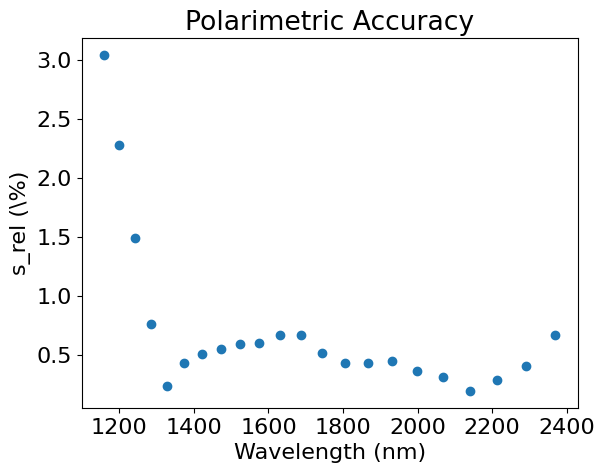

In [8]:
# LINEAR NAIVE HWP AND LINER DER NAIVE, DER ELLIP PHI_H STARTING GUESS
import matplotlib.pyplot as plt
plt.scatter(wavelength_bins,sres_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('s_rel (\%)')
plt.title('Polarimetric Accuracy')
#plt.savefig('/home/thomasmc/nbs_in/polcal_testing_2/plots/naive_linear_imr_scipy_physical_hwp_scipy_off.png')

`model_data` will list out all of your fits in a data frame.

In [11]:
from pyPolCal.csv_tools import model_data
json_dir = '../system_dictionaries/nbs_in_internalcal/'
df = model_data(json_dir, offsets=False)

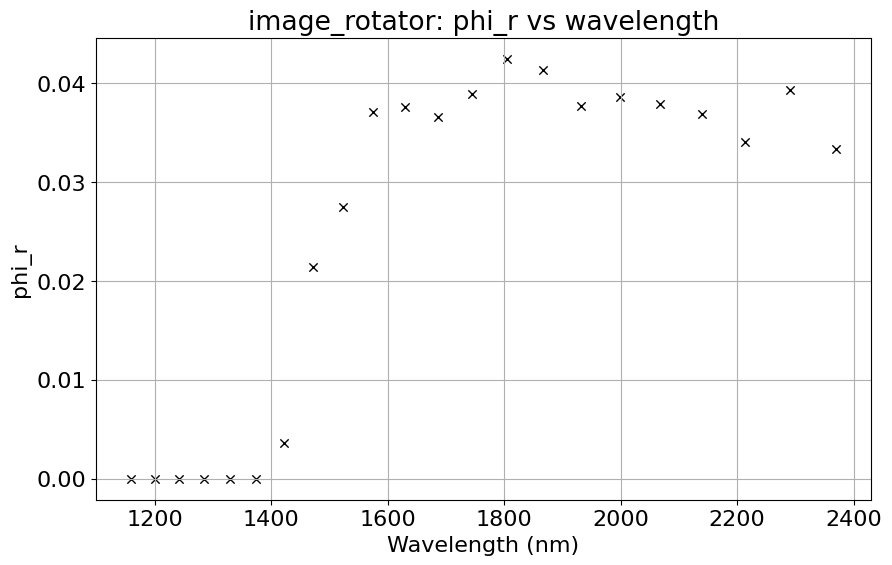

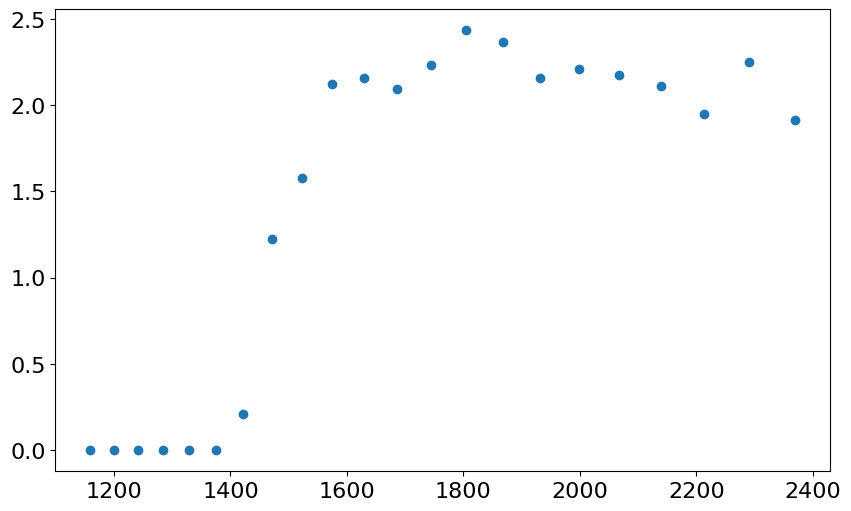

In [ ]:
# plot 45 degree linear retardance
from pyPolCal.plotting import plot_config_dict_vs_wavelength
params, fig, ax = plot_config_dict_vs_wavelength('image_rotator', 'phi_r', json_dir)
fig, ax = plt.subplots(figsize=(10,6))
# plot in degrees
ax.scatter(wavelength_bins, np.rad2deg(params))

# Step 4: Fit for Global Parameters

In [2]:
# Get interleaved values for all wavelength bins
csvdir = Path('../datacsvs/nbs_in_internalcal_csvs')

interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csvdir)

from pyPolCal.constants import wavelength_bins
wavelength_bin = 15 # placeholder
epsilon_cal = 1 # defining as perfect, reasoning in Joost t Hart 2021
offset_imr = -0.0018
offset_hwp = -0.0022 
offset_cal = -0.0315 
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
d = 259.7
wsio2 = 1.613
wmgf2 = 1.261

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
"components" : {
    "wollaston" : {
        "type" : "CHARIS_wollaston_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "beam": 'o'}, 
        "tag": "internal",
    },
            "nbs_rot": {
                "type": "rotator_function",
                "properties": {"pa": 90},
                "tag": "internal",
            },
    "image_rotator" : {
        "type" : "elliptical_IMR_function",
        "properties" : {"wavelength":wavelength_bins[wavelength_bin], "theta": imr_theta, "delta_theta": offset_imr},
        "tag": "internal",
    },
    "hwp" : {
        "type" : "two_layer_HWP_function",
        "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
        "tag": "internal",
    },
    "lprot": { # changed from delta_theta to match Joost t Hart
        "type": "rotator_function",
        "properties" : {'pa':offset_cal},
        "tag": "internal",
    },
    "lp" : {  # calibration polarizer for internal calibration source
        "type": "diattenuator_retarder_function",
        "properties": {"epsilon": epsilon_cal},
        "tag": "internal",
    }}
}
    
# Starting guesses

p0_dict = {
    "image_rotator" : 
        {"delta_theta": offset_imr},
    "hwp" :  
        {"w_SiO2": wsio2, "w_MgF2": wmgf2, "delta_theta": offset_hwp},
    "lprot" : 
        {"pa": offset_cal},
}

system_mm = generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM
print(system_mm.evaluate())
p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5,5) 
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.6*p0[0], 1.4*p0[0])
wmgf2_bounds = (0.6*p0[1], 1.4*p0[1])
bounds=[offset_bounds,wsio2_bounds,wmgf2_bounds,offset_bounds,offset_bounds]
# Process everything into double differences and propagate errors





[[ 0.00632227  0.00632227  0.          0.        ]
 [-0.00632152 -0.00632152  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [3]:
# Minimize everything globally with minimize
from pyPolCal.fitting import minimize_system_mueller_matrix
result_min, logl_min=minimize_system_mueller_matrix(p0_dict,system_mm,interleaved_values_all,
                               configuration_list_all,s_in=[1,0,0,0],process_dataset=process_dataset,
                               process_errors=process_errors, process_model=process_model,include_sums=False,
                               bounds=bounds,mode='minimize')
print(result_min)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.17332047354064248
        x: [-4.506e-01  1.636e+00  1.278e+00 -1.119e+00 -5.905e-01]
      nit: 39
      jac: [-5.176e-06 -2.014e-04  2.665e-04  3.494e-04 -6.826e-04]
     nfev: 378
     njev: 63
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [4]:
# get errs
cov = result_min.hess_inv
errs = np.sqrt(np.diag(cov.todense()))
print("Errs:", errs)

Errs: [1. 1. 1. 1. 1.]


# Step 5: Redo Derotator and Wollaston Fits with Global Parameters

I have to edit the wrapper function before doing this with the results of the scipy minimize fit.

/home/thomasmc/miniconda3/envs/charisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2930e-02                                    1.18e+00    
       1              2         8.0363e-03      2.49e-02       8.15e-02       2.19e-01    
       2              3         6.5470e-03      1.49e-03       2.64e-02       4.57e-03    
       3              4         6.3000e-03      2.47e-04       2.39e-03       4.21e-05    
       4              5         6.2598e-03      4.02e-05       4.35e-04       4.05e-06    
       5              6         6.2586e-03      1.22e-06       1.35e-05       1.62e-07    
       6              7         6.2586e-03      1.21e-09       1.96e-08       1.25e-09    
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 3.2930e-02, final cost 6.2586e-03, first-order optimality 1.25e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 8.164e-04  2.457

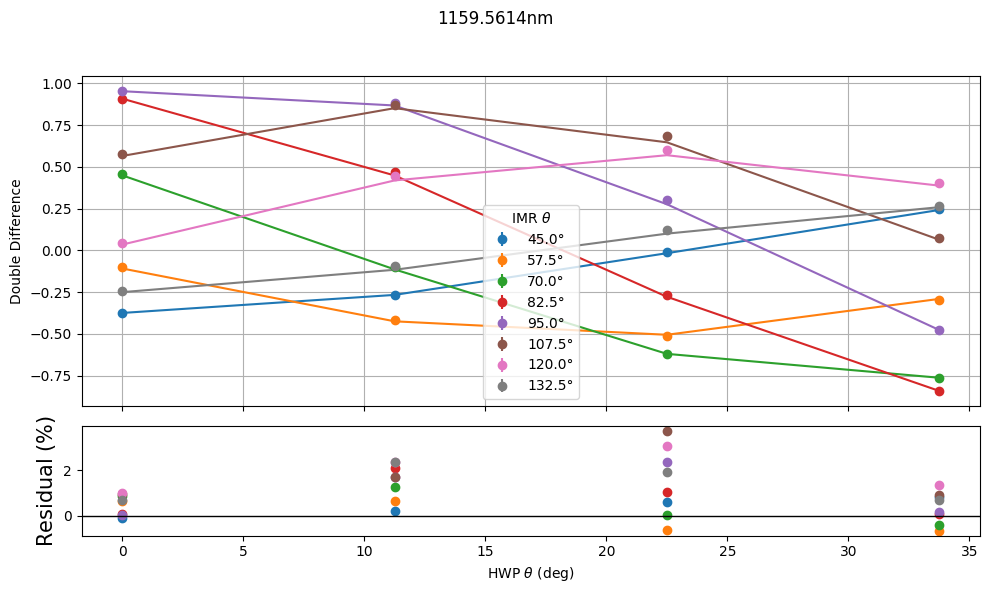

Updated Mueller Matrix:
[[ 0.3310713   0.33100097 -0.00682367  0.        ]
 [-0.3310713  -0.33100097  0.00682367  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6578866651596513 3.7424516756279473
s_res: 1.6644303752283922
Error: [0.00544693 0.01676096 0.01214918 0.00535711]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8450e-02                                    9.69e-01    
       1              2         6.0452e-03      2.24e-02       1.00e-01       5.39e-02    
       2              3         6.0119e-03      3.33e-05       4.40e-03       2.03e-04    
       3              4         6.0114e-03      5.35e-07       4.35e-04       3.05e-06    
       4              5         6.0114e-03      1.00e-09       1.99e-05       2.13e-07    
       5              6         6.0114e-03      8.15e-15       6.71e-08       1.65e

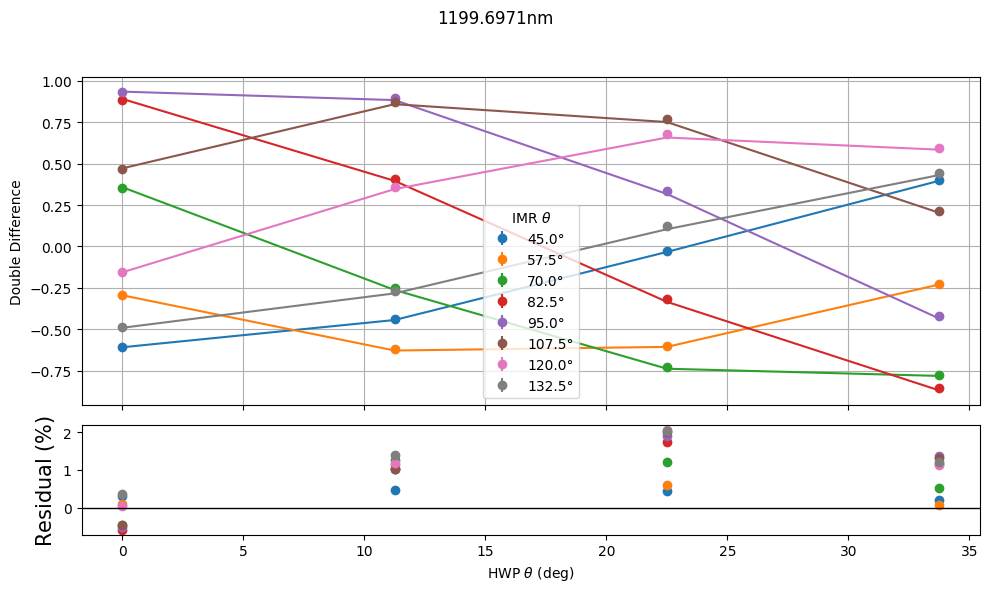

Updated Mueller Matrix:
[[ 0.24682492  0.24677249 -0.00508728  0.        ]
 [-0.24058342 -0.24053232  0.00495864  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.5876432384842332 2.0514591161255282
s_res: 1.2893509547806035
Error: [0.00678286 0.01767164 0.00952654 0.00523201]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8806e-02                                    1.34e+00    
       1              2         4.1421e-03      2.47e-02       1.15e-01       8.53e-02    
       2              3         4.0734e-03      6.87e-05       5.16e-03       1.12e-04    
       3              4         4.0704e-03      3.08e-06       1.15e-03       5.52e-05    
       4              5         4.0703e-03      4.38e-08       1.55e-04       8.87e-06    
       5              6         4.0703e-03      2.12e-11       3.91e-06       2.57e

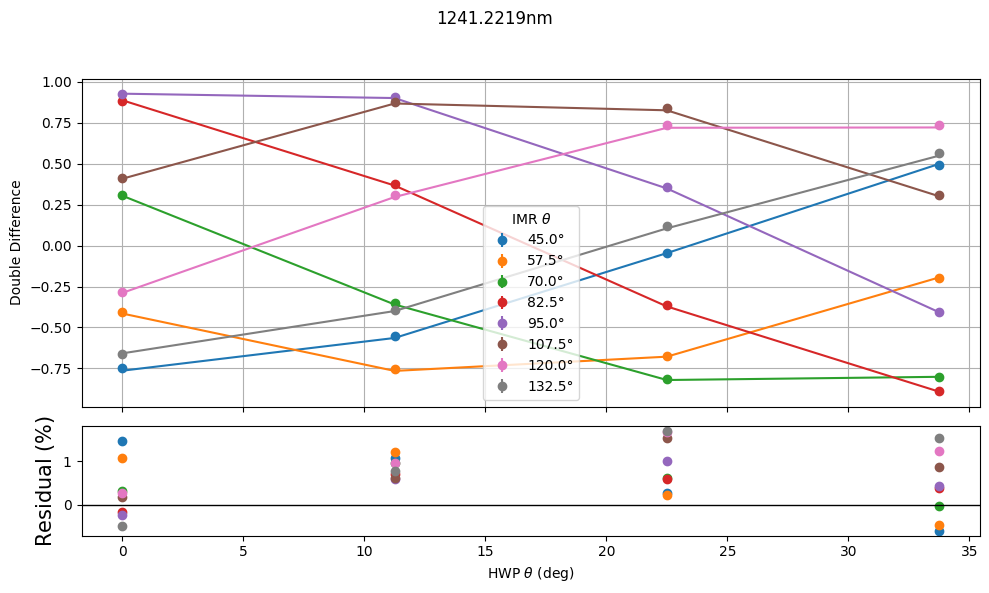

Updated Mueller Matrix:
[[ 0.19096548  0.19092491 -0.00393597  0.        ]
 [-0.1859504  -0.18591089  0.0038326   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.5983025899797383 1.6892169335920197
s_res: 1.033831534657514
Error: [0.00715727 0.01629043 0.00673591 0.00427556]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0867e-02                                    2.00e+00    
       1              2         6.4879e-03      2.44e-02       1.27e-01       1.32e-01    
       2              3         6.3497e-03      1.38e-04       7.84e-03       5.39e-04    
       3              4         6.3468e-03      2.85e-06       1.68e-03       2.76e-04    
       4              5         6.3468e-03      1.45e-08       1.50e-04       2.77e-05    
       5              6         6.3468e-03      5.10e-11       9.32e-06       1.79e-

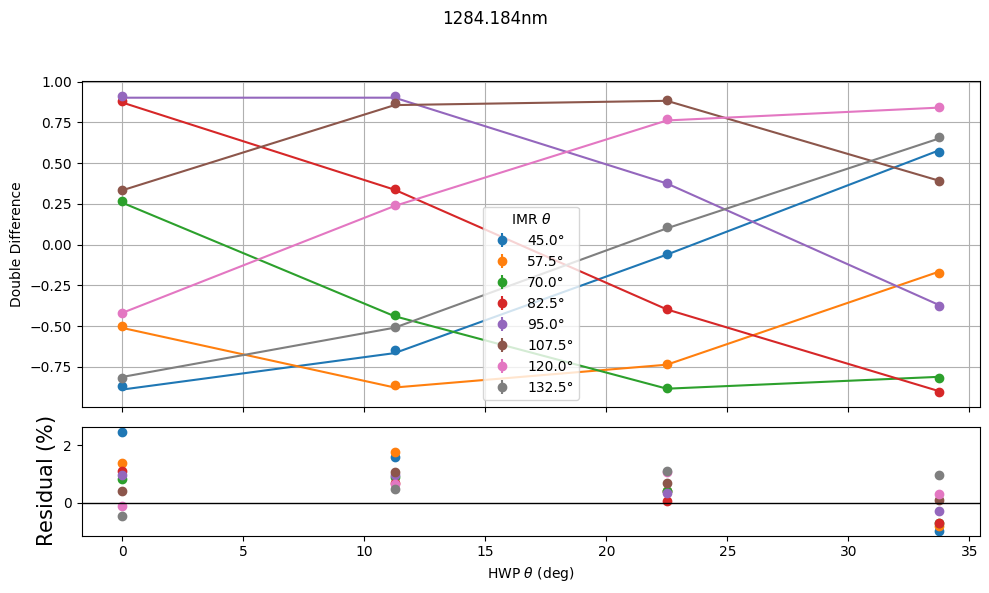

Updated Mueller Matrix:
[[ 0.14790359  0.14787217 -0.00304842  0.        ]
 [-0.12981781 -0.12979024  0.00267566  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.9664045350187251 2.4675540620273324
s_res: 1.0842357697939689
Error: [0.01351896 0.02656003 0.00736574 0.00521676]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8668e-02                                    2.46e+00    
       1              2         1.1585e-02      1.71e-02       6.80e-02       7.64e-02    
       2              3         1.1557e-02      2.83e-05       8.29e-03       5.98e-03    
       3              4         1.1539e-02      1.84e-05       9.14e-03       6.69e-03    
       4              5         1.1516e-02      2.31e-05       1.02e-02       7.46e-03    
       5              6         1.1487e-02      2.88e-05       1.14e-02       8.26e

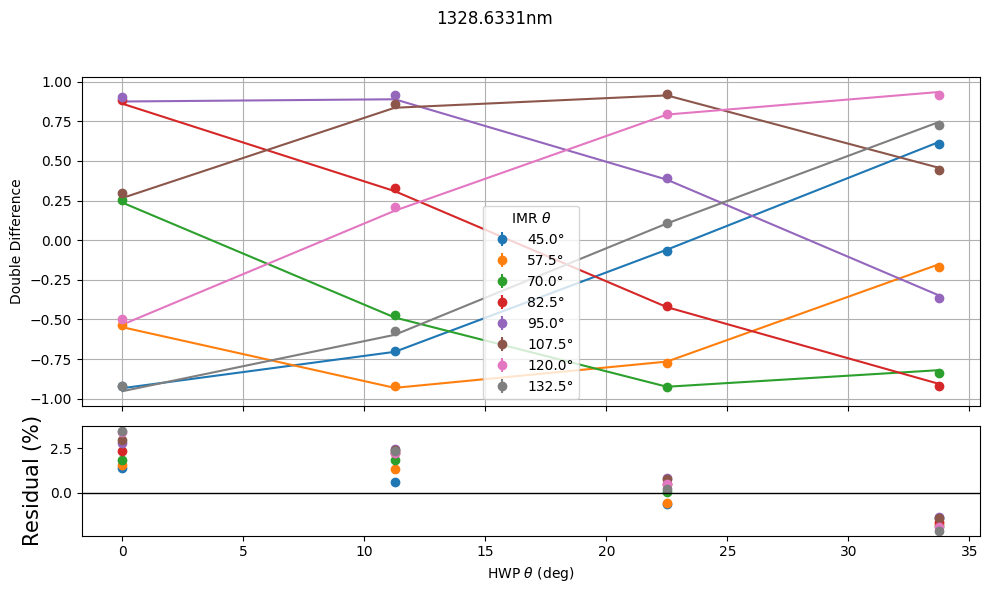

Updated Mueller Matrix:
[[ 0.13110523  0.13107738 -0.00270219  0.        ]
 [-0.09888004 -0.09885904  0.002038    0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -2.1157249269542433 3.4756740097065517
s_res: 2.1640443727646352
Error: [0.03641604 0.05913862 0.00792543 0.00567294]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8404e-02                                    2.55e+00    
       1              2         4.7565e-03      1.36e-02       7.57e-02       8.30e-03    
       2              3         4.7404e-03      1.61e-05       2.52e-03       1.29e-04    
       3              4         4.7400e-03      3.49e-07       6.07e-04       3.99e-05    
       4              5         4.7400e-03      4.41e-10       2.67e-05       1.83e-06    
       5              6         4.7400e-03      2.31e-13       6.66e-07       5.63e

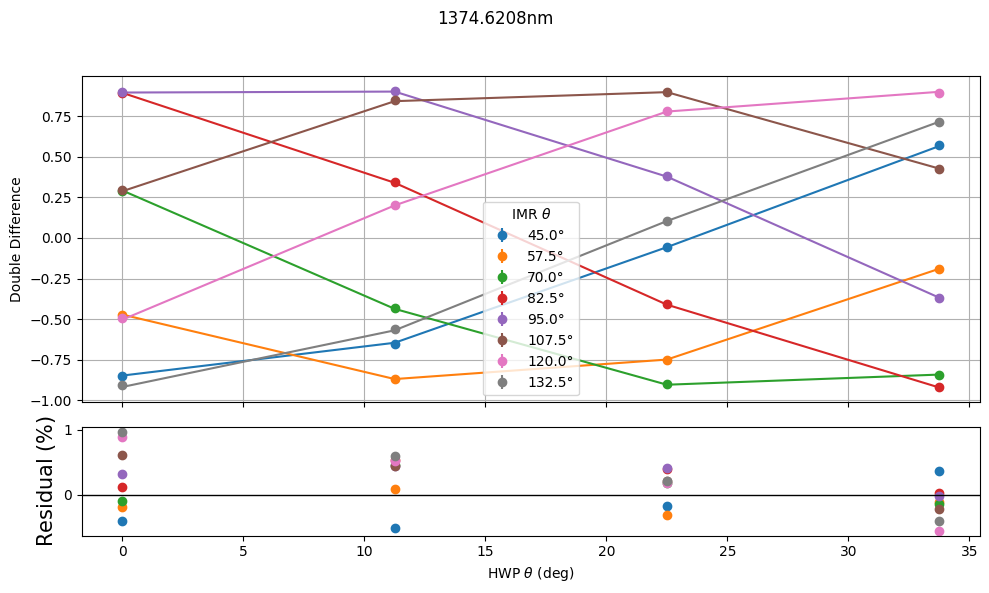

Updated Mueller Matrix:
[[ 0.16277707  0.1627425  -0.00335498  0.        ]
 [-0.15274487 -0.15271242  0.00314821  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.5494489008250838 0.9643654010756819
s_res: 0.476860335366885
Error: [0.01248313 0.01836009 0.00462407 0.00441916]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5219e-02                                    2.77e+00    
       1              2         2.0943e-03      1.31e-02       5.87e-02       2.52e-02    
       2              3         2.0816e-03      1.27e-05       3.67e-03       2.66e-04    
       3              4         2.0816e-03      4.41e-08       1.83e-04       2.50e-05    
       4              5         2.0816e-03      8.64e-12       3.62e-06       2.55e-07    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.52

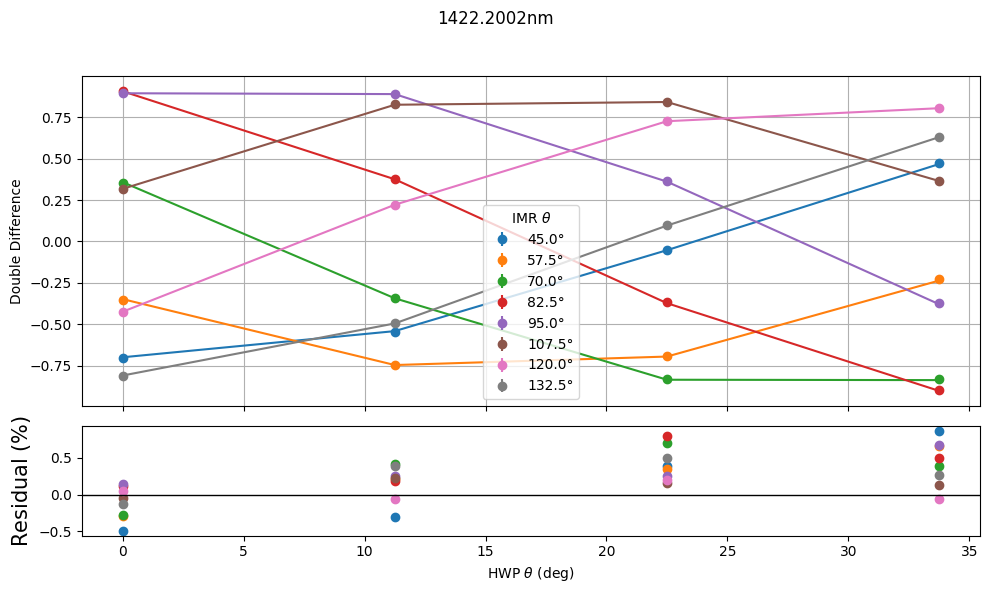

Updated Mueller Matrix:
[[ 0.21846076  0.21841436 -0.00450267  0.        ]
 [-0.20895187 -0.20890748  0.00430668  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.49142632231234984 0.8683876161984259
s_res: 0.4556661381435563
Error: [0.00559075 0.00793197 0.00297272 0.003016  ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2703e-02                                    2.41e+00    
       1              2         2.0111e-03      1.07e-02       5.57e-02       2.55e-02    
       2              3         2.0059e-03      5.26e-06       1.22e-03       7.90e-05    
       3              4         2.0058e-03      2.93e-08       1.05e-04       7.04e-06    
       4              5         2.0058e-03      1.73e-12       7.88e-07       4.72e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.

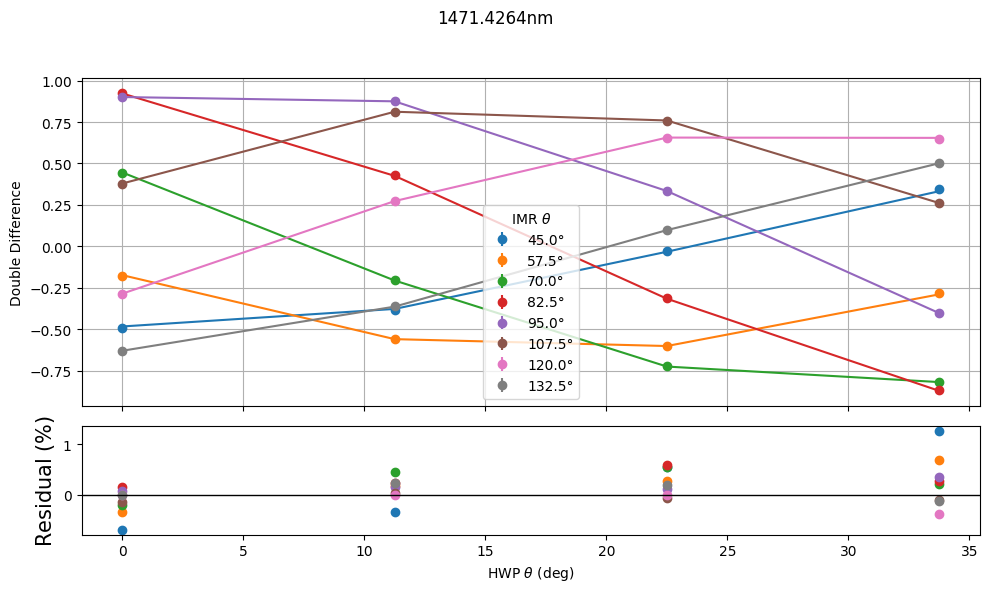

Updated Mueller Matrix:
[[ 0.29504423  0.29498155 -0.00608112  0.        ]
 [-0.28709967 -0.28703868  0.00591738  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6990866647449607 1.272220403734977
s_res: 0.4453711791633125
Error: [0.0039326  0.00546411 0.00290691 0.00299282]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.6485e-03                                    1.91e+00    
       1              2         1.9606e-03      7.69e-03       5.05e-02       1.56e-02    
       2              3         1.9570e-03      3.64e-06       1.01e-03       5.06e-05    
       3              4         1.9570e-03      1.61e-08       6.97e-05       2.15e-06    
       4              5         1.9570e-03      5.51e-13       3.90e-07       1.40e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 9.64

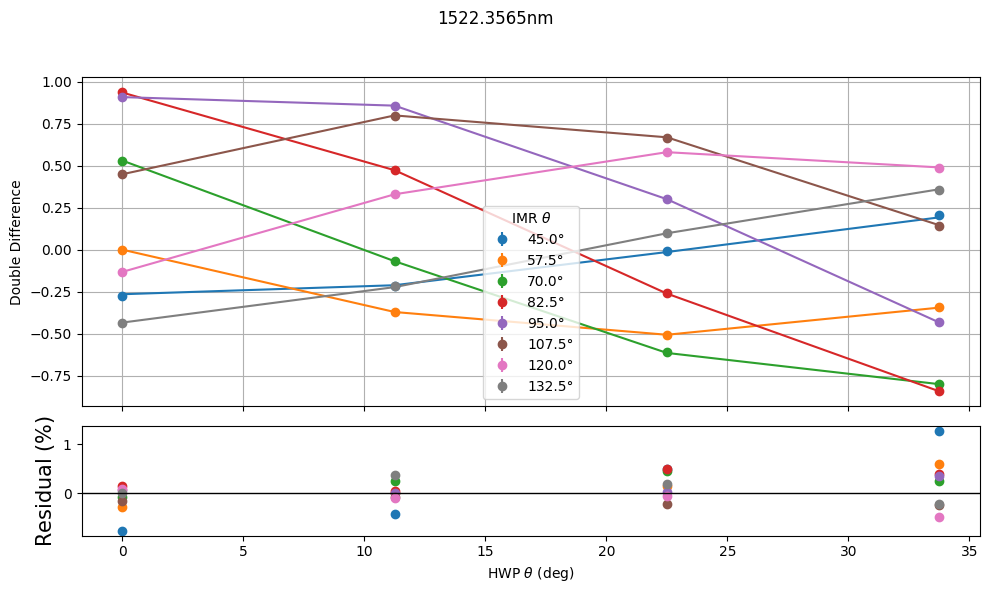

Updated Mueller Matrix:
[[ 0.37346244  0.3733831  -0.00769739  0.        ]
 [-0.36667842 -0.36660053  0.00755756  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.7657057552779349 1.2671951040447844
s_res: 0.4363798109736345
Error: [0.00315631 0.0042516  0.002944   0.00296855]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.9755e-03                                    1.56e+00    
       1              2         7.8925e-04      8.19e-03       5.42e-02       1.62e-02    
       2              3         7.8392e-04      5.33e-06       1.18e-03       2.94e-05    
       3              4         7.8389e-04      2.93e-08       8.94e-05       6.55e-07    
       4              5         7.8389e-04      2.00e-12       7.43e-07       4.04e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 8.9

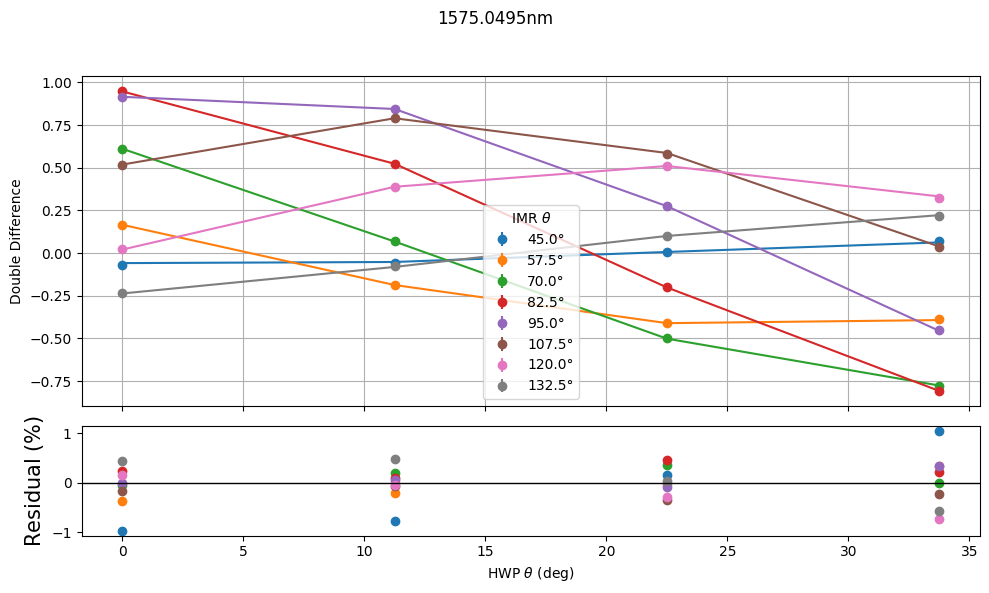

Updated Mueller Matrix:
[[ 0.44619929  0.44610451 -0.00919656  0.        ]
 [-0.44032742 -0.44023388  0.00907554  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.9664613908752031 1.0478445518706456
s_res: 0.4630795949674679
Error: [0.00179731 0.00227232 0.00194868 0.00188126]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0659e-02                                    1.40e+00    
       1              2         2.3803e-03      8.28e-03       5.35e-02       1.36e-02    
       2              3         2.3740e-03      6.28e-06       1.21e-03       4.14e-05    
       3              4         2.3740e-03      2.87e-08       8.78e-05       5.66e-08    
       4              5         2.3740e-03      1.50e-12       6.40e-07       4.21e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 1.0

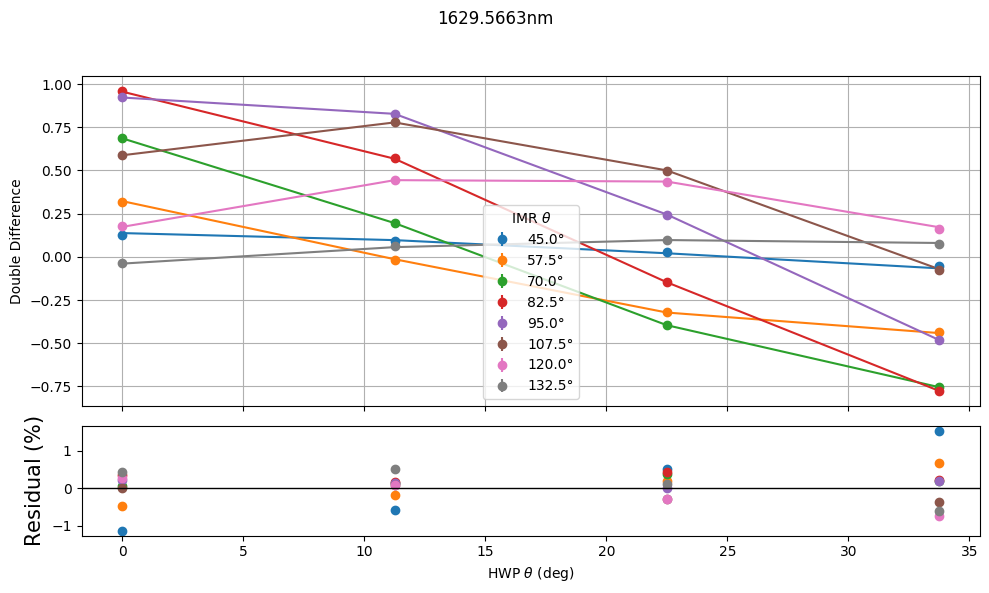

Updated Mueller Matrix:
[[ 0.51728196  0.51717207 -0.01066164  0.        ]
 [-0.51146838 -0.51135973  0.01054181  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.1366282002157604 1.5406199977116355
s_res: 0.5596218255118661
Error: [0.0030724  0.00346609 0.0036233  0.00327545]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0503e-02                                    1.67e+00    
       1              2         2.9356e-03      7.57e-03       4.97e-02       1.09e-02    
       2              3         2.9301e-03      5.53e-06       1.10e-03       3.80e-05    
       3              4         2.9301e-03      1.83e-08       7.14e-05       3.63e-08    
       4              5         2.9301e-03      5.56e-13       3.99e-07       7.08e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 1.0

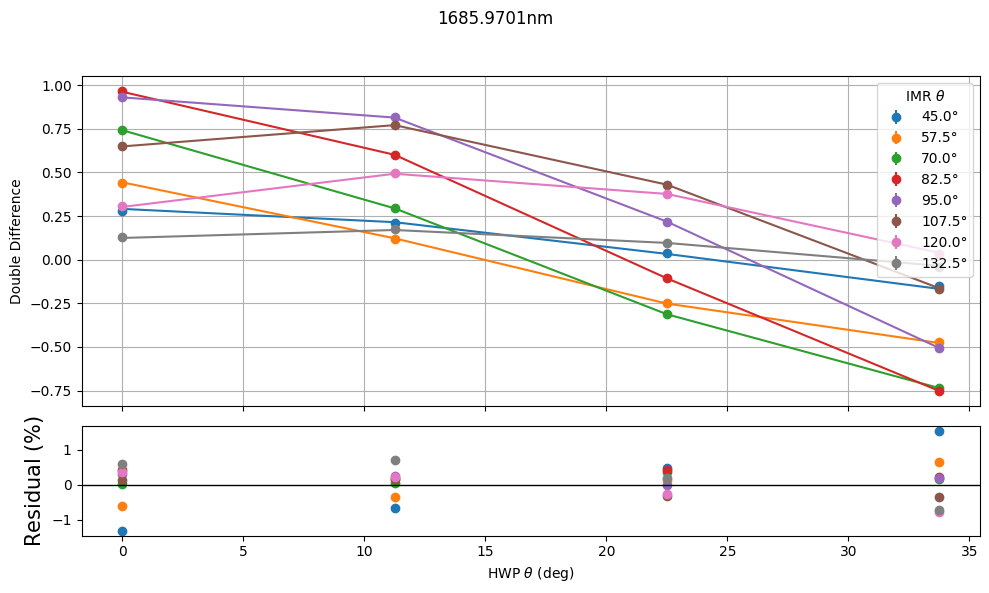

Updated Mueller Matrix:
[[ 0.57231163  0.57219005 -0.01179585  0.        ]
 [-0.56685416 -0.56673375  0.01168336  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.3162339091154216 1.5398927142641163
s_res: 0.6124181423710489
Error: [0.00357235 0.00351642 0.00432261 0.00363857]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7004e-03                                    2.06e+00    
       1              2         5.6003e-04      8.14e-03       4.90e-02       1.33e-02    
       2              3         5.5441e-04      5.63e-06       1.04e-03       7.25e-06    
       3              4         5.5438e-04      2.74e-08       9.02e-05       6.95e-07    
       4              5         5.5438e-04      1.58e-12       6.98e-07       6.44e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 8.7

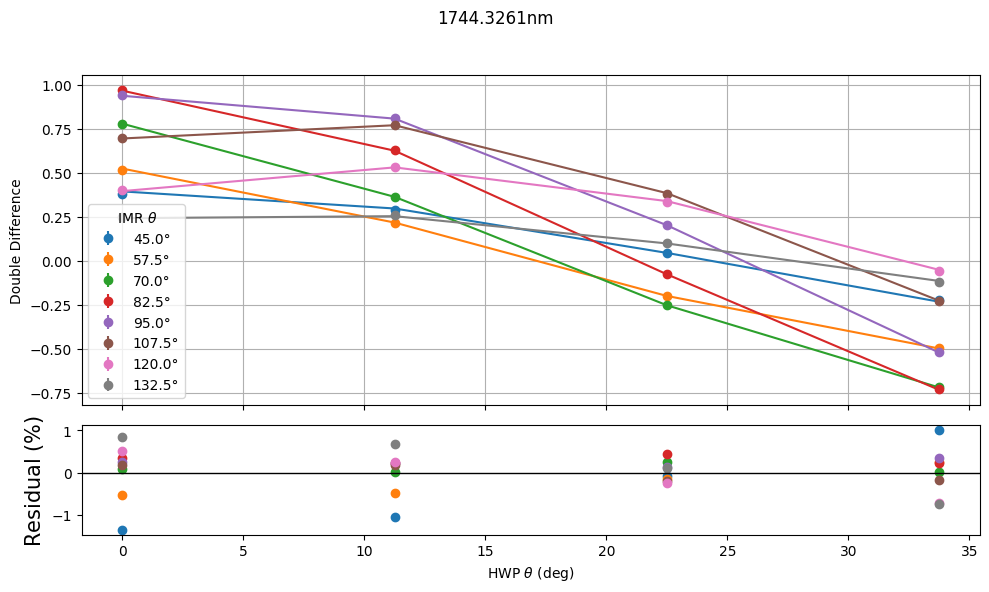

Updated Mueller Matrix:
[[ 0.60809449  0.60796532 -0.01253336  0.        ]
 [-0.6036765  -0.60354826  0.0124423   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.3558660483739189 1.0173563141984623
s_res: 0.5822860563858336
Error: [0.00165199 0.00144201 0.00199728 0.00158267]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0200e-02                                    2.47e+00    
       1              2         4.4152e-04      9.76e-03       5.15e-02       2.61e-02    
       2              3         4.3409e-04      7.43e-06       1.17e-03       1.14e-05    
       3              4         4.3405e-04      4.19e-08       1.16e-04       1.57e-06    
       4              5         4.3405e-04      2.89e-12       9.78e-07       1.09e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.0

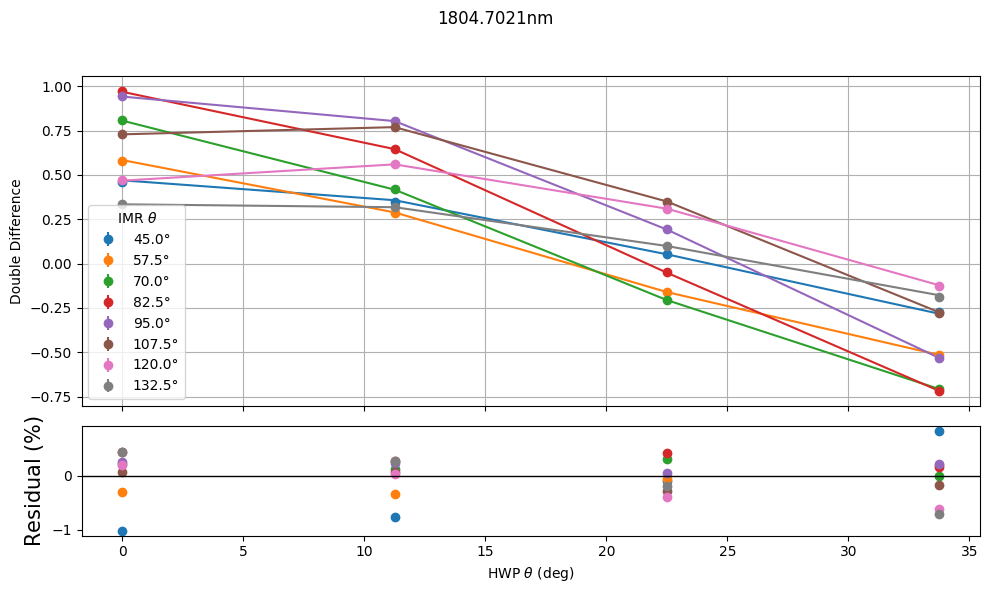

Updated Mueller Matrix:
[[ 0.63412431  0.63398961 -0.01306986  0.        ]
 [-0.62947967 -0.62934596  0.01297413  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.022289714651599 0.8360833514810935
s_res: 0.4519606880366485
Error: [0.00156491 0.00122569 0.00187452 0.00140111]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5958e-02                                    2.62e+00    
       1              2         6.7562e-03      9.20e-03       4.63e-02       2.73e-02    
       2              3         6.7505e-03      5.74e-06       1.01e-03       5.04e-05    
       3              4         6.7504e-03      2.74e-08       9.87e-05       8.84e-06    
       4              5         6.7504e-03      1.66e-12       8.23e-07       7.67e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.59

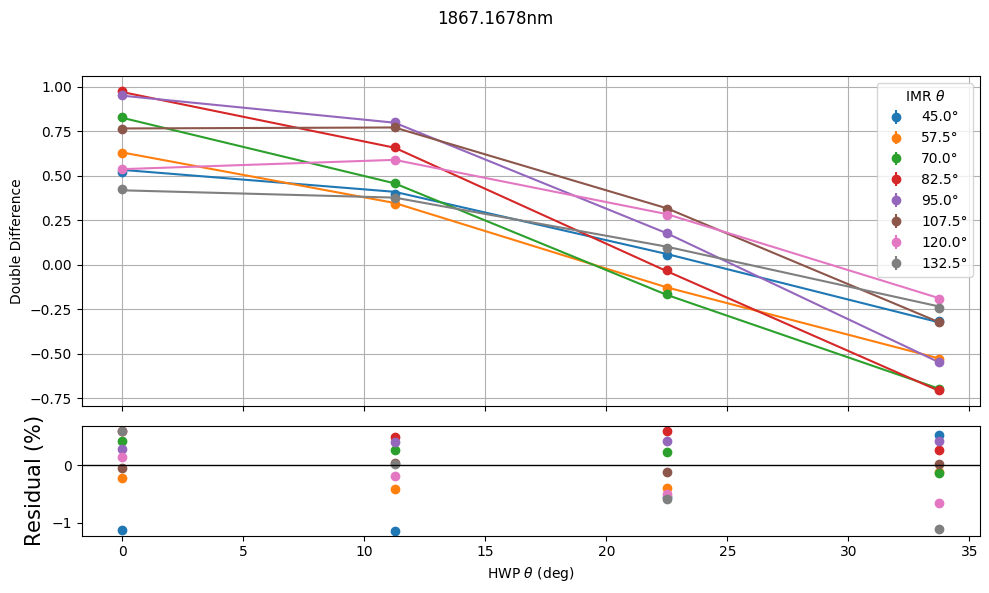

Updated Mueller Matrix:
[[ 0.65545779  0.65531856 -0.01350956  0.        ]
 [-0.65106134 -0.65092303  0.01341895  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.1375125225085512 0.6043826465178337
s_res: 0.5828561204305672
Error: [0.00663388 0.00466975 0.00784557 0.00553191]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9645e-02                                    2.50e+00    
       1              2         1.1829e-02      7.82e-03       4.13e-02       2.44e-02    
       2              3         1.1825e-02      3.93e-06       8.36e-04       4.51e-05    
       3              4         1.1825e-02      1.24e-08       6.90e-05       8.00e-06    
       4              5         1.1825e-02      5.63e-13       5.32e-07       9.01e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.9

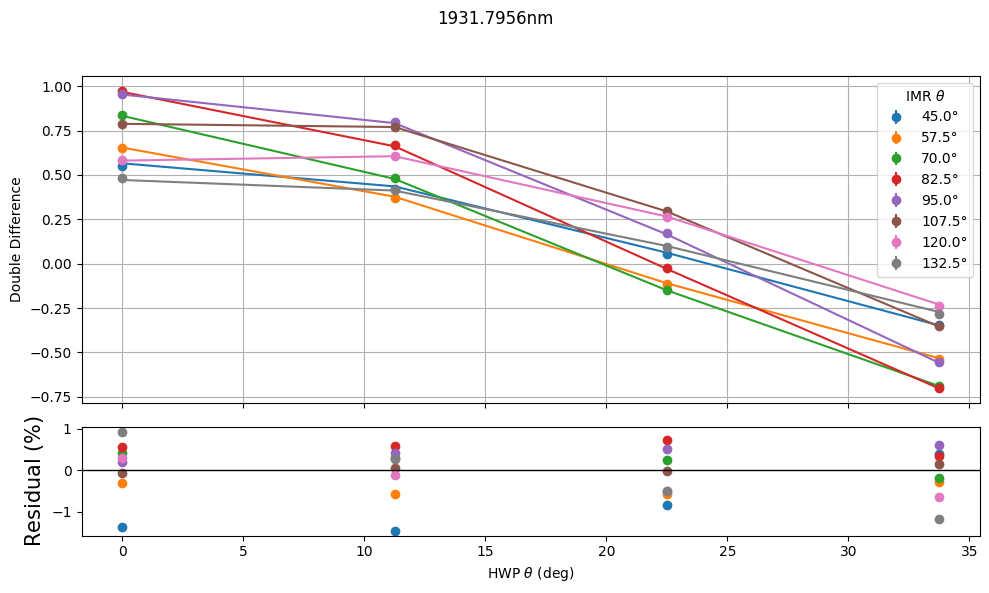

Updated Mueller Matrix:
[[ 0.66738964  0.66724787 -0.01375549  0.        ]
 [-0.66290651 -0.66276569  0.01366309  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.458075711055983 0.9334559329685845
s_res: 0.6934239584679466
Error: [0.00924527 0.00605972 0.01083097 0.00733823]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3042e-02                                    2.62e+00    
       1              2         1.4523e-02      8.52e-03       4.37e-02       2.52e-02    
       2              3         1.4518e-02      4.76e-06       9.17e-04       5.11e-05    
       3              4         1.4518e-02      2.81e-08       1.06e-04       1.14e-05    
       4              5         1.4518e-02      2.56e-12       1.10e-06       1.23e-07    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.30

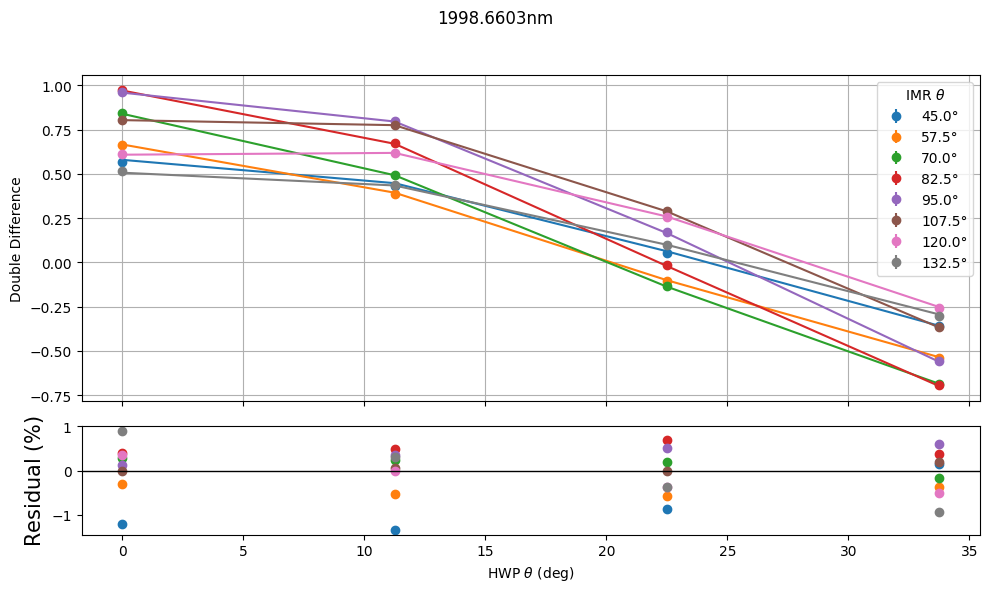

Updated Mueller Matrix:
[[ 0.6716007   0.67145804 -0.01384228  0.        ]
 [-0.66803521 -0.6678933   0.01376879  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.3388507598596249 0.8928131168068418
s_res: 0.6220960792031145
Error: [0.01051811 0.00662461 0.01225621 0.00815404]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2251e-02                                    2.58e+00    
       1              2         1.3770e-02      8.48e-03       4.53e-02       2.09e-02    
       2              3         1.3765e-02      5.07e-06       9.77e-04       4.00e-05    
       3              4         1.3765e-02      2.35e-08       9.86e-05       7.41e-06    
       4              5         1.3765e-02      1.13e-12       7.47e-07       5.63e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.2

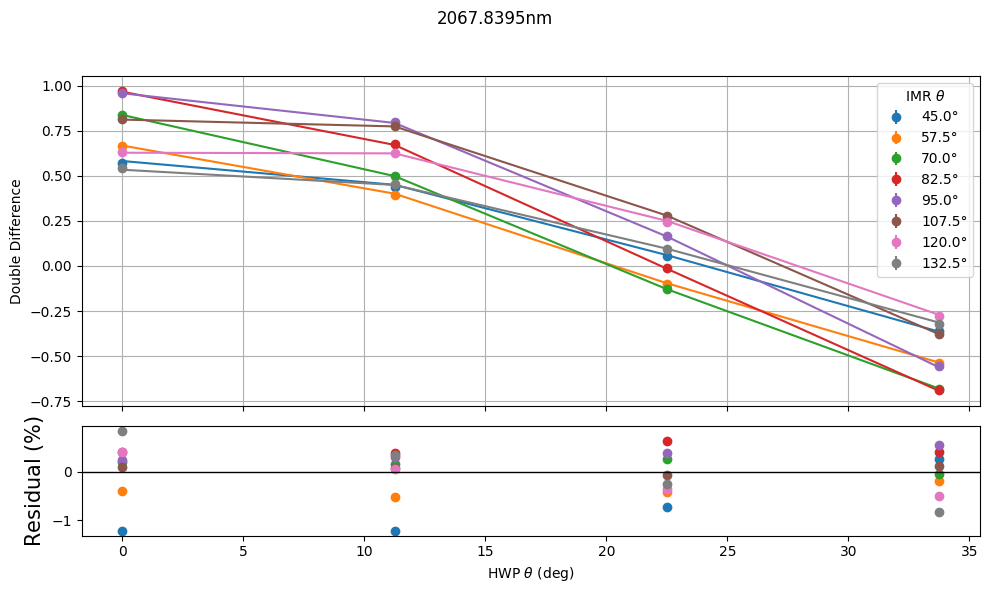

Updated Mueller Matrix:
[[ 0.67312486  0.67298187 -0.0138737   0.        ]
 [-0.66858133 -0.6684393   0.01378005  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.2088860628799267 0.8335526093170387
s_res: 0.5729688803998578
Error: [0.01052333 0.00641631 0.01220995 0.00796234]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4949e-02                                    2.50e+00    
       1              2         1.6517e-02      8.43e-03       4.77e-02       1.76e-02    
       2              3         1.6512e-02      5.60e-06       1.05e-03       2.46e-05    
       3              4         1.6512e-02      3.35e-08       1.18e-04       4.29e-06    
       4              5         1.6512e-02      1.98e-12       9.38e-07       3.11e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.4

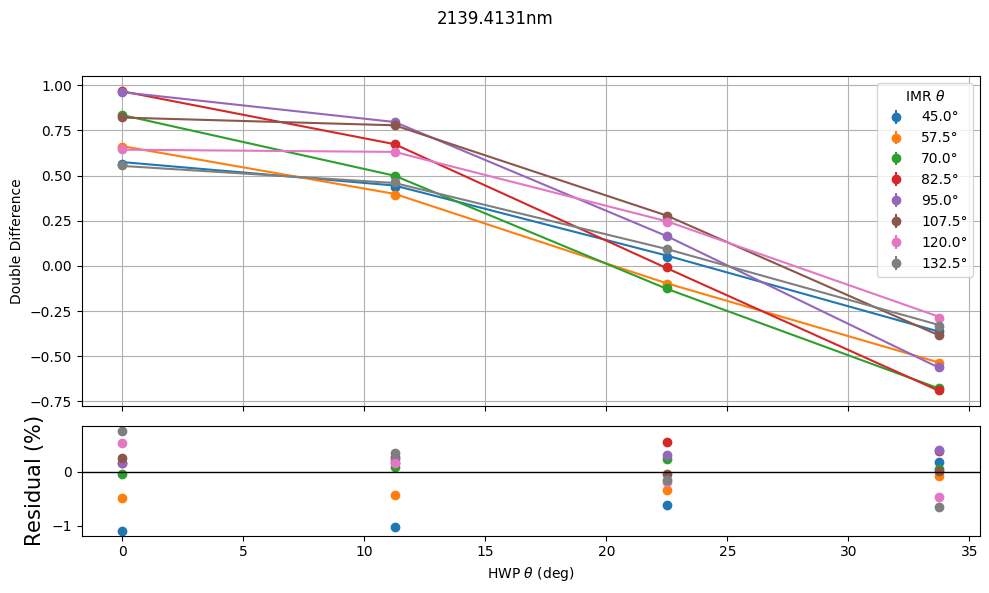

Updated Mueller Matrix:
[[ 0.67057179  0.67042934 -0.01382107  0.        ]
 [-0.6663081  -0.66616656  0.0137332   0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.0876043576117027 0.7544376174975582
s_res: 0.4965558093481769
Error: [0.01159793 0.00700063 0.01344695 0.00874032]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5175e-02                                    2.24e+00    
       1              2         1.7338e-02      7.84e-03       5.01e-02       1.27e-02    
       2              3         1.7332e-02      6.08e-06       1.19e-03       9.78e-06    
       3              4         1.7332e-02      1.93e-08       8.90e-05       9.41e-08    
       4              5         1.7332e-02      3.02e-13       3.47e-07       8.88e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 2.5

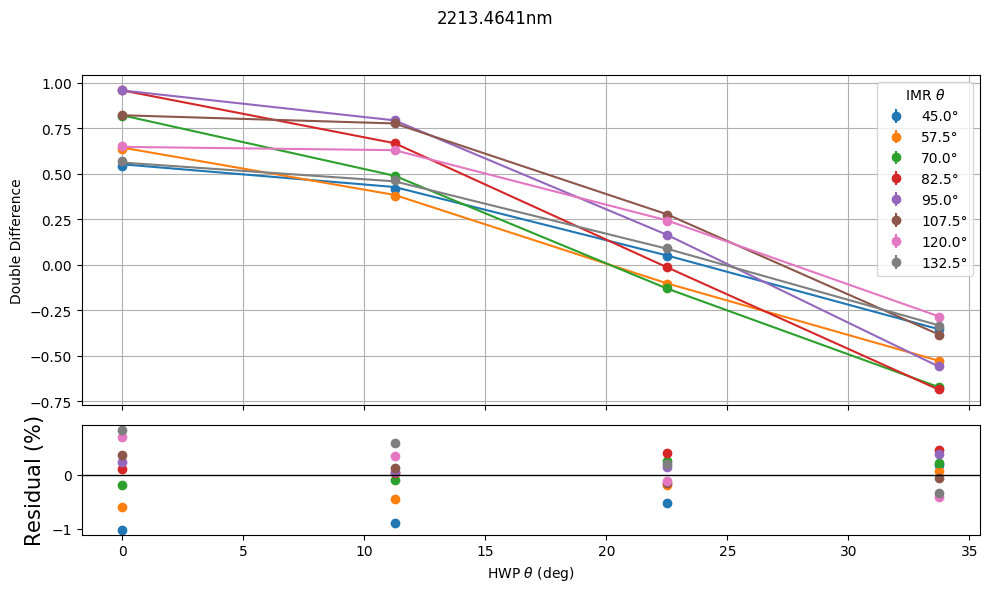

Updated Mueller Matrix:
[[ 0.6636964   0.66355541 -0.01367937  0.        ]
 [-0.65757259 -0.6574329   0.01355315  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.017274594072049 0.8358952231813674
s_res: 0.4872275663726674
Error: [0.01187083 0.00722246 0.01379416 0.00896259]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7360e-02                                    2.51e+00    
       1              2         1.6488e-02      1.09e-02       6.08e-02       3.08e-02    
       2              3         1.6476e-02      1.26e-05       1.72e-03       2.46e-05    
       3              4         1.6476e-02      3.55e-08       1.17e-04       5.39e-07    
       4              5         1.6476e-02      7.59e-13       5.70e-07       4.47e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.73

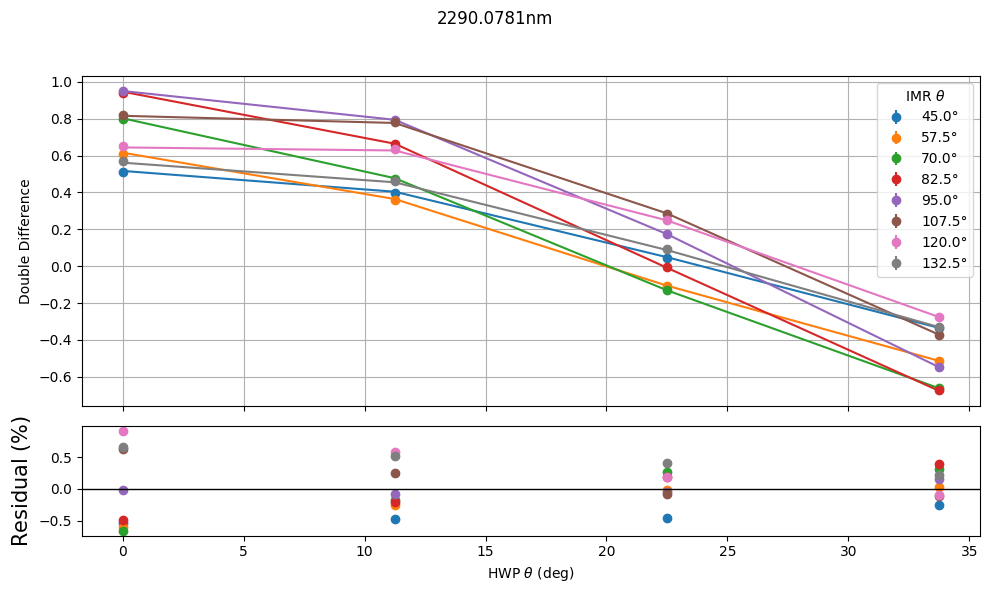

Updated Mueller Matrix:
[[ 0.65097171  0.65083342 -0.0134171   0.        ]
 [-0.64223165 -0.64209522  0.01323696  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -0.6588715990745158 0.9193025919999371
s_res: 0.4557861812622841
Error: [0.01143838 0.00713334 0.01335723 0.00872835]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7873e-02                                    1.96e+00    
       1              2         1.7856e-02      1.00e-02       6.43e-02       4.21e-02    
       2              3         1.7837e-02      1.85e-05       2.70e-03       2.02e-04    
       3              4         1.7837e-02      4.67e-09       3.36e-05       5.23e-07    
       4              5         1.7837e-02      2.64e-14       1.11e-07       2.41e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.7

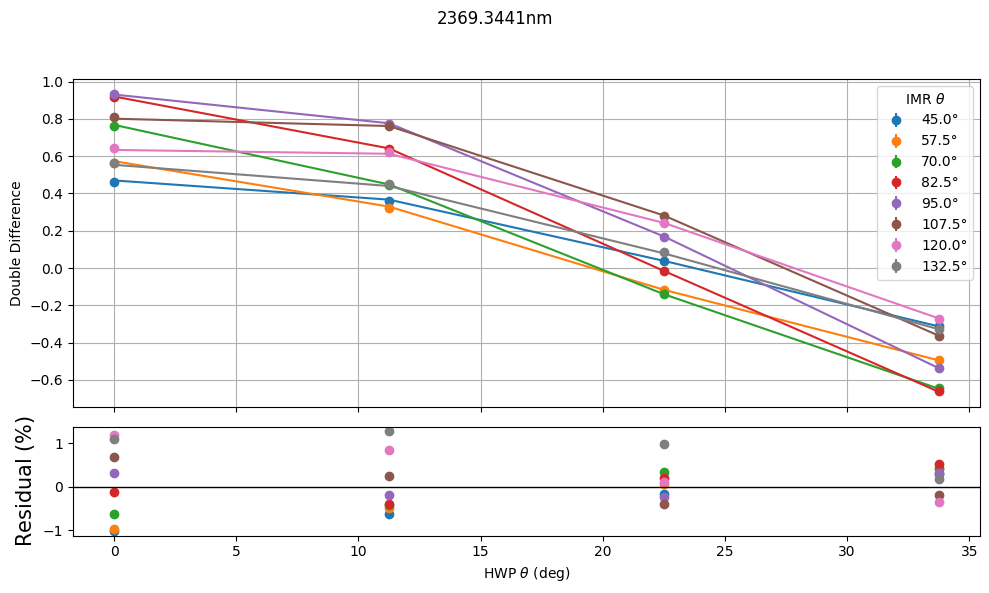

Updated Mueller Matrix:
[[ 0.63711192  0.63697658 -0.01313144  0.        ]
 [-0.6203398  -0.62020802  0.01278575  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
128 64
Residuals range: -1.016169027620144 1.2691104273428522
s_res: 0.686884017608057
Error: [0.01188289 0.00765434 0.01396048 0.00904576]


In [1]:
from pyPolCal.instruments import fit_CHARIS_Mueller_matrix_by_bin_nbs
from pathlib import Path
errors = []
sres_list = []
for bin in range(0,22):
    error,fig,ax,sres = fit_CHARIS_Mueller_matrix_by_bin_nbs(
        f'../datacsvs/nbs_in_internalcal_csvs/bin{bin}.csv',bin,
        Path(f'../system_dictionaries/nbs_in_internalcal/bin{bin}.json'),
    )
    errors.append(error)
    sres_list.append(sres)



Text(0.5, 1.0, 'Polarimetric Accuracy')

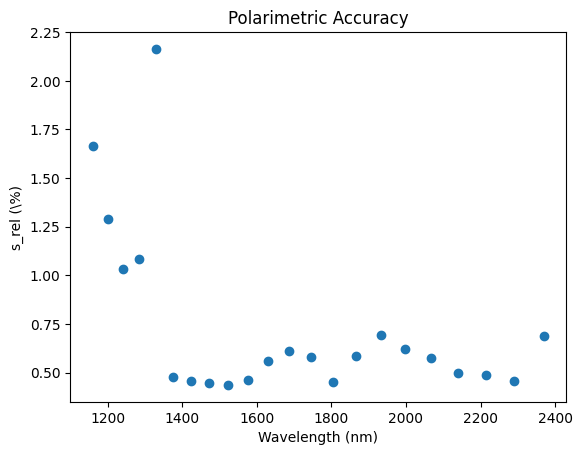

In [2]:
import matplotlib.pyplot as plt
from pyPolCal.constants import wavelength_bins
plt.scatter(wavelength_bins,sres_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('s_rel (\%)')
plt.title('Polarimetric Accuracy')
#plt.savefig('/home/thomasmc/nbs_in/polcal_testing_2/plots/naive_linear_imr_scipy_physical_hwp_scipy_off.png')